# 0. Librairies And Parameters

## Calculus & Data Manipulation

In [610]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.feature_selection import f_classif


## Data Visualization

In [611]:
import matplotlib.pyplot as plt
import seaborn as sns

## General

In [612]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(1415)
RANDOM_STATE = 1415

## Variables

### Model Variables

In [613]:
train_df = None
test_df = None
X_train = None
X_val = None
y_train = None
y_val = None
X_test_processed = None
feature_names = []
label_encoders = {}
best_model = None
feature_importance = None
hypothesis_results = {}
best_model

### Calculus Variables

In [614]:
# Outliers variables
k_outliers = 1.5
limit_outliers = 0.05

# p value for hypothesis
p_value_threshold = 0.05

# Bagging variables
number_estimator_bagging = 20

# Dataset variables
dataset_test_size = 0.2

# Bootstrap sample variables
rf_model_n_estimators = 150

# Parameters for the random search of finetuning
# Lists of option to chose from
param_grid_n_estimators = [50, 100, 125, 150, 175, 200]
param_grid_max_depth = [1, 2, 3, 5, 6, 8, 9, 10, 12, 13, 15, None]
param_grid_min_samples_split = [2, 3, 4, 5, 6]
param_grid_min_samples_leaf = [1, 2, 3, 4]
param_grid_max_features = ['sqrt', 'log2', None]
param_grid_bootstrap = [True, False]
# Random search
random_search_n_iter = 100
random_search_cv = 5
random_search_scoring = 'accuracy'
random_search_n_jobs = -1
random_search_random_state = RANDOM_STATE
random_search_verbose = 1
# Grid search
grid_search_cv = 10
grid_search_scoring = 'accuracy'
grid_search_n_jobs = -1
grid_search_verbose = 1

# Finetuning variables
fine_tune_range_n_estimators = 50 # Normal : 50
fine_tune_range_max_depth = 5 # Normal : 5
fine_tune_range_min_samples_split = 2 # Normal : 2
fine_tune_range_min_samples_leaf = 1 # Normal : 1


### Aesthetic Variables

In [615]:
# Lenght of equal signs for Title in the Terminal (not important)
len_equal_signs = 60

# 1. Data Cleaning and Handling of Missing Values (up to 0.5 pt):

## Clearly demonstrate the data preparation process, including how missing values and outliers that may compromise analysis quality were handled.


### The data preparation process begins by loading the training and test datasets, followed by checking for missing values, duplicates, and outliers. Duplicate rows were removed to prevent redundancy.
### For missing values, numerical features were imputed using either the mean (for normally distributed variables) or the median (for skewed variables), while categorical features were filled with the label “Unknown.” Outliers in numerical columns were detected using the interquartile range (IQR) method, and when they represented less than 5% of the data, they were capped at the nearest acceptable boundary (winsorization) rather than removed, to preserve valuable information. These functions ensures that the final dataset is clean and consistent for analysis.

In [616]:
def load_and_clean_data(train_path='../data/train.csv', test_path='../data/test.csv'):
    # Global variables
    global train_df, test_df

    print("=" * len_equal_signs)
    print("1. DATA CLEANING AND HANDLING OF MISSING VALUES")
    print("=" * len_equal_signs)

    # Data loading
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # print data informations
    print(f"Training data: {train_df.shape}")
    print(f"Test data: {test_df.shape}")

    # Missing values analysis
    print("\n--- MISSING VALUES ANALYSIS ---")
    # Check if there is missing values in the training dataset
    missing_train = train_df.isnull().sum().sort_values(ascending=False)
    missing_train = missing_train[missing_train > 0]

    # If there is missing values
    if len(missing_train) > 0:
        print("Missing values in training data:")
        # Display percentage of missing values
        for col, missing_count in missing_train.items():
            missing_pct = (missing_count / len(train_df)) * 100
            print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")
    # If there is no missing values
    else:
        print("No missing values detected in training data!")

    # Duplicate analysis
    print(f"\n--- DUPLICATE ANALYSIS ---")
    # Count the duplicates
    duplicates = train_df.duplicated().sum()
    print(f"Number of duplicates: {duplicates}")

    # If there is duplicates
    if duplicates > 0:
        print("Removing duplicates...")
        train_df = train_df.drop_duplicates()
        # Print new set dimension
        print(f"New dimensions after removal: {train_df.shape}")
    # If there is not duplicates
    else:
        print("No duplicates detected in training data!")

    # Outlier detection and treatment for numerical variables
    print(f"\n--- OUTLIER DETECTION AND TREATMENT ---")

    # Select all numerical columns from the training dataset
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

    # Remove 'labels' column if present
    if 'labels' in numeric_cols:
        numeric_cols.remove('labels')
    # Remove 'id' column if present
    if 'id' in numeric_cols:
        numeric_cols.remove('id')

    # Dictionary to store outlier information for each column
    outliers_info = {}

    # Iterate through each numerical column to detect and treat outliers
    for col in numeric_cols:
        # Verify the column exists in the dataframe
        if col in train_df.columns:
            # Calculate the first quartile (25th percentile)
            Q1 = train_df[col].quantile(0.25)

            # Calculate the third quartile (75th percentile)
            Q3 = train_df[col].quantile(0.75)

            # Calculate the Interquartile Range (IQR)
            IQR = Q3 - Q1

            # Calculate the lower bound for outlier detection
            # Using k_outliers multiplier
            lower_bound = Q1 - k_outliers * IQR

            # Calculate the upper bound for outlier detection
            upper_bound = Q3 + k_outliers * IQR

            # Identify outliers: values that fall outside the bounds
            outliers = train_df[(train_df[col] < lower_bound) |
                                (train_df[col] > upper_bound)][col]

            # Store the count of outliers for this column
            outliers_info[col] = len(outliers)

            # If outliers are detected in this column
            if len(outliers) > 0:
                # Print the percentage of outliers
                print(
                    f"  {col}: {len(outliers)} outliers detected ({len(outliers) / len(train_df) * 100:.1f}%)")

                # Only treat outliers if their proportion is below the limit threshold
                if len(outliers) / len(train_df) < limit_outliers:
                    # Winsorization : cap values at upper bound
                    train_df[col] = np.where(train_df[col] > upper_bound, upper_bound, train_df[col])
                    # Winsorization : floor values at lower bound
                    train_df[col] = np.where(train_df[col] < lower_bound, lower_bound, train_df[col])

                    print(f"    -> Outliers treated by winsorization")

    # Display the final dimensions of the cleaned training dataset
    print(f"\nFinal dimensions after cleaning: {train_df.shape}")

    # Return both cleaned training and original test dataframes
    return train_df, test_df

In [617]:
def handle_missing_values(df_train, df_test):
    print("\n--- MISSING VALUES HANDLING ---")

    # Copy to avoid modifying originals
    train_processed = df_train.copy()
    test_processed = df_test.copy()

    # Identify numerical and categorical columns
    numeric_cols = train_processed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = train_processed.select_dtypes(include=['object']).columns.tolist()

    # Remove id column as it's not a feature
    if 'id' in numeric_cols:
        numeric_cols.remove('id')
    # Same for labels
    if 'labels' in numeric_cols:
        numeric_cols.remove('labels')

    # Display variable counts
    print(f"Numerical variables: {len(numeric_cols)}")
    print(f"Categorical variables: {len(categorical_cols)}")

    # Handle numerical variables
    print("\nNumerical variables treatment:")
    # Loop through each numerical column
    for col in numeric_cols:
        # Check if column exists in training data
        if col in train_processed.columns:
            # Count missing values in training set
            missing_train = train_processed[col].isnull().sum()
            # Count missing values in test set
            missing_test = test_processed[col].isnull().sum() if col in test_processed.columns else 0

            # Process only if missing values exist
            if missing_train > 0 or missing_test > 0:
                # Display missing counts for this column
                print(f"  {col}: {missing_train} missing (train), {missing_test} missing (test)")

                # Check if distribution is skewed by comparing std to mean
                if train_processed[col].std() > train_processed[col].mean():
                    # Use median for skewed distributions
                    fill_value = train_processed[col].median()
                    strategy = "median"
                else:
                    # Use mean for approximately normal distributions
                    fill_value = train_processed[col].mean()
                    strategy = "mean"

                # Fill missing values in training set
                train_processed[col].fillna(fill_value, inplace=True)
                # Fill missing values in test set with same value from training
                if col in test_processed.columns:
                    test_processed[col].fillna(fill_value, inplace=True)

                print(f"    -> Replacement with {strategy} ({fill_value:.2f})")

    # Handle categorical variables
    print("\nCategorical variables treatment:")
    # Loop through each categorical column
    for col in categorical_cols:
        # Check if column exists in training data
        if col in train_processed.columns:
            # Count missing values in training set
            missing_train = train_processed[col].isnull().sum()
            # Count missing values in test set
            missing_test = test_processed[col].isnull().sum() if col in test_processed.columns else 0

            # Process only if missing values exist
            if missing_train > 0 or missing_test > 0:
                # Display missing counts for this column
                print(f"  {col}: {missing_train} missing (train), {missing_test} missing (test)")

                # Fill with 'Unknown' category in training set
                train_processed[col].fillna('Unknown', inplace=True)
                # Fill with 'Unknown' category in test set
                if col in test_processed.columns:
                    test_processed[col].fillna('Unknown', inplace=True)

                print(f"    -> Replacement with 'Unknown'")

    print("\nMissing values handling completed")

    # Return processed dataframes
    return train_processed, test_processed

# 2. Categorical Variable Encoding (up to 0.5 pt):

## Apply appropriate encoding techniques to transform categorical variables into formats compatible with predictive models, while preserving relevant information.

### This function prepares categorical variables for modeling by converting them into numeric form. First, it identifies all categorical columns in the training data and analyzes the number of unique values each one contains.
### Based on this cardinality, different encoding strategies are applied: if a column has only two unique values, it is transformed using simple binary encoding (0/1). If it has up to 10 categories, label encoding is used, assigning a numeric code to each category.
### For columns with many categories, the function reduces complexity by keeping only the 10 most frequent categories and grouping the rest as “Other,” then applies one-hot encoding to create separate indicator columns.
### To ensure consistency between train and test sets, encoders are fitted on combined data, and missing columns are aligned.
### Finally, all encoded columns are converted to numeric types, missing values are filled with 0, and the resulting datasets are returned ready for analysis.



In [618]:
def encode_categorical_variables(train_df_input, test_df_input):
    # Global variables
    global label_encoders

    print("=" * len_equal_signs)
    print("2. CATEGORICAL VARIABLE ENCODING")
    print("=" * len_equal_signs)

    # Copy dataframes to avoid modifying originals
    train_encoded = train_df_input.copy()
    test_encoded = test_df_input.copy()

    # Identify all categorical columns (object type)
    categorical_cols = train_encoded.select_dtypes(include=['object']).columns.tolist()

    # Display columns to be encoded
    print(f"Categorical variables to encode: {categorical_cols}")

    # Loop through each categorical column
    for col in categorical_cols:
        # Check if column exists in training data
        if col in train_encoded.columns:
            print(f"\n--- Encoding {col} ---")

            # Count unique values in train and test sets
            unique_values_train = train_encoded[col].nunique()
            unique_values_test = test_encoded[col].nunique() if col in test_encoded.columns else 0

            # Display cardinality information
            print(f"Unique values - Train: {unique_values_train}, Test: {unique_values_test}")
            # Show first 5 sample values
            print(f"Sample values: {train_encoded[col].unique()[:5]}")

            # Choose encoding strategy based on cardinality
            if unique_values_train <= 2:
                # Binary encoding for 2 or fewer categories
                print("Strategy: Binary encoding (0/1)")
                le = LabelEncoder()

                # Combine train and test data to ensure consistent encoding
                combined_data = pd.concat([
                    train_encoded[col],
                    test_encoded[col] if col in test_encoded.columns else pd.Series(dtype='object')
                ], ignore_index=True).dropna()

                # Fit encoder on combined data
                le.fit(combined_data)

                # Transform training data
                train_encoded[col] = le.transform(train_encoded[col])
                # Transform test data if column exists
                if col in test_encoded.columns:
                    test_encoded[col] = le.transform(test_encoded[col])

                # Store encoder for potential inverse transformation
                label_encoders[col] = le

            elif unique_values_train <= 10:
                # Label encoding for low cardinality
                print("Strategy: Label Encoding")
                le = LabelEncoder()

                # Combine train and test data for consistent encoding
                combined_data = pd.concat([
                    train_encoded[col],
                    test_encoded[col] if col in test_encoded.columns else pd.Series(dtype='object')
                ], ignore_index=True).dropna()

                # Fit encoder on combined data
                le.fit(combined_data)

                # Transform training data
                train_encoded[col] = le.transform(train_encoded[col])
                # Transform test data if column exists
                if col in test_encoded.columns:
                    test_encoded[col] = le.transform(test_encoded[col])

                # Store encoder for potential inverse transformation
                label_encoders[col] = le

            else:
                # One-hot encoding for high cardinality (>10 categories)
                print("Strategy: One-Hot Encoding (top 10 categories)")

                # Select top 10 most frequent categories
                top_categories = train_encoded[col].value_counts().head(10).index.tolist()

                # Replace rare categories with 'Other' in training set
                train_encoded[col] = train_encoded[col].apply(
                    lambda x: x if x in top_categories else 'Other'
                )
                # Replace rare categories with 'Other' in test set
                if col in test_encoded.columns:
                    test_encoded[col] = test_encoded[col].apply(
                        lambda x: x if x in top_categories else 'Other'
                    )

                # Create dummy variables for training set
                train_dummies = pd.get_dummies(train_encoded[col], prefix=col)
                # Create dummy variables for test set
                test_dummies = pd.get_dummies(test_encoded[col],
                                              prefix=col) if col in test_encoded.columns else pd.DataFrame()

                # Get all possible dummy column names from both sets
                all_cols = set(train_dummies.columns)
                if not test_dummies.empty:
                    all_cols.update(test_dummies.columns)

                # Ensure both train and test have same dummy columns
                for dummy_col in all_cols:
                    # Add missing column to train set
                    if dummy_col not in train_dummies.columns:
                        train_dummies[dummy_col] = 0
                    # Add missing column to test set
                    if not test_dummies.empty and dummy_col not in test_dummies.columns:
                        test_dummies[dummy_col] = 0

                # Remove original categorical column from training set
                train_encoded = train_encoded.drop(col, axis=1)
                # Add dummy columns to training set
                train_encoded = pd.concat([train_encoded, train_dummies], axis=1)

                # Process test set if not empty
                if not test_dummies.empty:
                    # Remove original categorical column from test set
                    test_encoded = test_encoded.drop(col, axis=1)
                    # Add dummy columns to test set
                    test_encoded = pd.concat([test_encoded, test_dummies], axis=1)

            print(f"{col} successfully encoded")

    # Convert all feature columns to numeric type
    for col in train_encoded.columns:
        # Skip id and target columns
        if col not in ['id', 'labels']:
            # Convert to numeric, coercing errors to NaN
            train_encoded[col] = pd.to_numeric(train_encoded[col], errors='coerce')
            # Convert test column if it exists
            if col in test_encoded.columns:
                test_encoded[col] = pd.to_numeric(test_encoded[col], errors='coerce')

    # Fill any remaining NaN values with 0
    train_encoded = train_encoded.fillna(0)
    test_encoded = test_encoded.fillna(0)

    print(f"\nEncoding completed")
    print(f"Final dimensions:"
          f"    Train : {train_encoded.shape},"
          f"    Test : {test_encoded.shape}")

    # Return both encoded datasets
    return train_encoded, test_encoded

# 3. Data Exploration and Visualization (up to 2.0 pts):

## Conduct a thorough exploratory analysis to identify patterns, correlations, and trends. Use graphs and tables to justify your choice of features and models.

### The exploration routine first summarizes dataset size and target balance (success vs failure), then identifies numeric and categorical features and produces a set of visual and tabular diagnostics : a target-distribution pie, boxplots of numeric features split by label (e.g., funding rounds, relationships, age), histograms (with log-scale for skewed funding amounts), and bar charts showing category-level success percentages (crosstabs).
### It then computes a numeric correlation matrix (heatmap) and prints the strongest correlations with the target, followed by descriptive statistics for each numeric feature split by class and a simple t-test to check whether class differences are significant. Together, the graphs and crosstabs reveal which variables separate successful from failed cases (high absolute correlation, strong per-category success-rate differences, significant t-test results, or visible distribution shifts), which suggests how to prepare features (e.g., log-transform highly skewed funding, keep top geographic flags, encode discriminative categories) and which model families to try first (linear models or regularized logistic regression when relationships are mostly linear and features few/highly predictive; tree-based or ensemble models when non-linear interactions and categorical splits dominate).


In [619]:
def comprehensive_data_exploration():
    # Global variables
    global train_df

    print("=" * len_equal_signs)
    print("3. DATA EXPLORATION AND VISUALIZATION")
    print("=" * len_equal_signs)

    # Display basic dataset information
    print("--- DATA OVERVIEW ---")
    print(f"Total number of samples: {len(train_df)}")
    # Exclude target variable from feature count
    print(f"Number of variables: {train_df.shape[1] - 1}")

    # Analyze target variable distribution
    print(f"\n--- TARGET VARIABLE DISTRIBUTION ---")
    # Count occurrences of each class
    target_counts = train_df['labels'].value_counts()
    # Calculate success percentage
    success_rate = target_counts[1] / len(train_df) * 100
    # Calculate failure percentage
    failure_rate = target_counts[0] / len(train_df) * 100

    # Display class distribution
    print(f"Success (1): {target_counts[1]} ({success_rate:.1f}%)")
    print(f"Failure (0): {target_counts[0]} ({failure_rate:.1f}%)")
    # Show balance ratio between classes
    print(f"Success/Failure Ratio: {target_counts[1] / target_counts[0]:.2f}")

    # Identify numerical and categorical features
    numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

    # Remove target variable from numerical features
    if 'labels' in numeric_features:
        numeric_features.remove('labels')
    # Remove id column from numerical features
    if 'id' in numeric_features:
        numeric_features.remove('id')

    # Display feature types
    print(f"\n--- VARIABLE TYPES ---")
    print(f"Numerical variables ({len(numeric_features)}): {numeric_features}")
    print(f"Categorical variables ({len(categorical_features)}): {categorical_features}")

    # Generate exploratory plots
    create_exploratory_visualizations(numeric_features, categorical_features)

    # Perform correlation analysis
    analyze_correlations(numeric_features)

    # Analyze categorical variable patterns
    analyze_categorical_patterns(categorical_features)

    # Compute detailed statistics by class
    detailed_statistical_analysis(numeric_features)

In [620]:
def create_exploratory_visualizations(numeric_features, categorical_features):
    # Global variables
    global train_df

    # Create 2x3 subplot grid for main visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Exploratory Data Analysis - Overview', fontsize=16, fontweight='bold')

    # Create pie chart for target variable distribution
    target_counts = train_df['labels'].value_counts()
    # Define colors for failure (red) and success (green)
    colors = ['#ff7f7f', '#7fbf7f']
    axes[0, 0].pie(target_counts.values, labels=['Failure (0)', 'Success (1)'],
                   autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0, 0].set_title('Startup Success Distribution')

    # Plot funding rounds boxplot by success status
    if 'funding_rounds' in train_df.columns:
        train_df.boxplot(column='funding_rounds', by='labels', ax=axes[0, 1])
        axes[0, 1].set_title('Funding Rounds by Success')
        axes[0, 1].set_xlabel('Success (0=Failure, 1=Success)')

    # Plot total funding distribution by success status
    if 'funding_total_usd' in train_df.columns:
        # Extract funding data for success class
        success_funding = train_df[train_df['labels'] == 1]['funding_total_usd'].dropna()
        # Extract funding data for failure class
        failure_funding = train_df[train_df['labels'] == 0]['funding_total_usd'].dropna()

        # Create histogram if both classes have data
        if len(success_funding) > 0 and len(failure_funding) > 0:
            # Plot overlapping histograms for both classes
            axes[0, 2].hist([failure_funding, success_funding], bins=30, alpha=0.7,
                            label=['Failure', 'Success'], color=['red', 'green'])
            axes[0, 2].set_xlabel('Total Funding (USD)')
            axes[0, 2].set_ylabel('Frequency')
            axes[0, 2].set_title('Total Funding Distribution')
            axes[0, 2].legend()
            # Use log scale for better visualization of wide range
            axes[0, 2].set_yscale('log')

    # Plot relationships boxplot by success status
    if 'relationships' in train_df.columns:
        train_df.boxplot(column='relationships', by='labels', ax=axes[1, 0])
        axes[1, 0].set_title('Number of Relationships by Success')
        axes[1, 0].set_xlabel('Success (0=Failure, 1=Success)')

    # Plot geographic distribution by success status
    # Select all geographic indicator columns (starting with 'is_')
    geo_cols = [col for col in train_df.columns if col.startswith('is_')]
    if geo_cols:
        # Group geographic data by target variable and sum
        geo_data = train_df[geo_cols + ['labels']].groupby('labels').sum()
        # Create bar chart for geographic distribution
        geo_data.plot(kind='bar', ax=axes[1, 1], width=0.8)
        axes[1, 1].set_title('Geographic Distribution by Success')
        axes[1, 1].set_xlabel('Success (0=Failure, 1=Success)')
        # Place legend outside plot area
        axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot age-related variable by success status
    # Select all age-related columns
    age_cols = [col for col in train_df.columns if 'age_' in col]
    if age_cols:
        # Plot only the first age column
        for i, col in enumerate(age_cols[:1]):
            train_df.boxplot(column=col, by='labels', ax=axes[1, 2])
            axes[1, 2].set_title(f'{col} by Success')
            axes[1, 2].set_xlabel('Success (0=Failure, 1=Success)')
            break

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    # Create separate figure for categorical variables analysis
    if categorical_features:
        # Calculate number of categorical features
        n_cat = len(categorical_features)
        # Set maximum 3 columns per row
        n_cols = min(3, n_cat)
        # Calculate required number of rows
        n_rows = (n_cat + 2) // 3

        # Create subplot grid for categorical variables
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        fig.suptitle('Categorical Variables Analysis', fontsize=16, fontweight='bold')

        # Reshape axes for consistent indexing
        if n_cat == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)

        # Loop through each categorical feature
        for i, col in enumerate(categorical_features):
            # Calculate subplot position
            row, col_idx = divmod(i, n_cols)
            # Select appropriate axis
            ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]

            # Create contingency table for category vs target
            crosstab = pd.crosstab(train_df[col], train_df['labels'])
            # Calculate percentage within each category
            crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

            # Plot percentage bar chart
            crosstab_pct.plot(kind='bar', ax=ax, width=0.8)
            ax.set_title(f'{col} Distribution by Success')
            ax.set_xlabel(col)
            ax.set_ylabel('Percentage')
            ax.legend(['Failure', 'Success'])
            # Rotate x-axis labels for readability
            ax.tick_params(axis='x', rotation=45)

        # Hide unused subplot axes
        for i in range(n_cat, n_rows * n_cols):
            # Calculate position of unused subplot
            row, col_idx = divmod(i, n_cols)
            # Hide axis based on grid structure
            if n_rows > 1:
                axes[row, col_idx].set_visible(False)
            elif n_cols > 1:
                axes[col_idx].set_visible(False)

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

In [621]:
def analyze_correlations(numeric_features):
    # Global variables
    global train_df

    print(f"\n--- CORRELATION ANALYSIS ---")

    # Include target variable in correlation matrix
    corr_features = numeric_features + ['labels']
    # Calculate correlation coefficients
    correlation_matrix = train_df[corr_features].corr()

    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    # Create upper triangle mask to avoid duplicate values
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    # Plot heatmap with annotations
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
                cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": .8})
    plt.title('Numerical Variables Correlation Matrix', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Extract correlations with target variable
    target_correlations = correlation_matrix['labels'].drop('labels').sort_values(key=abs, ascending=False)
    # Display top 10 strongest correlations with target
    print("Strongest correlations with target variable:")
    for var, corr in target_correlations.head(10).items():
        print(f"  {var}: {corr:.3f}")

In [622]:
def analyze_categorical_patterns(categorical_features):
    # Global variables
    global train_df

    print(f"\n--- CATEGORICAL PATTERN ANALYSIS ---")

    # Loop through each categorical feature
    for col in categorical_features:
        # Check if column exists
        if col in train_df.columns:
            print(f"\n{col}:")
            # Create contingency table (category vs target)
            crosstab = pd.crosstab(train_df[col], train_df['labels'])

            # Calculate success rate for each category
            success_rates = (crosstab[1] / (crosstab[0] + crosstab[1]) * 100).sort_values(ascending=False)

            # Display success rates by category
            print("  Success rate by category:")
            for category, rate in success_rates.items():
                # Count total samples in this category
                count = crosstab.loc[category].sum()
                print(f"    {category}: {rate:.1f}% ({count} samples)")

In [623]:
def detailed_statistical_analysis(numeric_features):
    # Global variables
    global train_df

    print(f"\n--- DETAILED DESCRIPTIVE STATISTICS ---")

    # Loop through each numerical feature
    for col in numeric_features:
        # Check if column exists
        if col in train_df.columns:
            print(f"\n{col}:")

            # Calculate statistics for success class
            success_stats = train_df[train_df['labels'] == 1][col].describe()
            # Calculate statistics for failure class
            failure_stats = train_df[train_df['labels'] == 0][col].describe()

            # Display mean and median for each class
            print(f"  Success - Mean: {success_stats['mean']:.2f}, Median: {success_stats['50%']:.2f}")
            print(f"  Failure - Mean: {failure_stats['mean']:.2f}, Median: {failure_stats['50%']:.2f}")

            # Import statistical test function
            from scipy import stats
            # Extract data for success class (remove NaN)
            success_data = train_df[train_df['labels'] == 1][col].dropna()
            # Extract data for failure class (remove NaN)
            failure_data = train_df[train_df['labels'] == 0][col].dropna()

            # Perform t-test if both classes have data
            if len(success_data) > 0 and len(failure_data) > 0:
                # Calculate t-statistic and p-value
                t_stat, p_value = stats.ttest_ind(success_data, failure_data)
                # Display p-value and significance status
                print(
                    f"  T-test - p-value: {p_value:.4f} {'(significant)' if p_value < p_value_threshold else '(non-significant)'}")

# 4. Hypothesis Formulation (up to 1.0 pt):

## Develop at least three hypotheses regarding factors that may influence the success of startups (e.g., quantity of employees, age etc).

### Three main hypotheses were formulated to explain the factors that may influence a startup’s success.
### The first suggests that the number of funding rounds is decisive, as each additional round reflects sustained investor confidence and supports growth; this is tested by comparing the average number of rounds between successful and failed startups, supported by boxplots.
### The second posits that the age at first funding plays a key role : securing funds earlier enables faster product development and quicker market entry; here, averages and a t-test are used to check whether successful startups indeed raise capital earlier.
### Finally, the third hypothesis focuses on the network of relationships, assuming that a larger network facilitates access to resources, partners, and opportunities; the analysis compares the average number of relationships between groups, again with visualizations.
### Together, these three hypothesis uses three different perspectives on the data : financial, temporal, and social, which provide a complementary approach to the understanding.


In [624]:
def formulate_and_test_hypotheses():
    print("=" * len_equal_signs)
    print("4. HYPOTHESIS FORMULATION")
    print("=" * len_equal_signs)

    print("Formulating three hypotheses about factors influencing startup success:\n")

    # State and test hypothesis 1 about funding rounds
    print("HYPOTHESIS 1: Impact of Number of Funding Rounds")
    print("H1: Startups with more funding rounds have a higher success rate")
    print("Justification: More rounds indicate sustained investor interest and progressive growth")

    # Test hypothesis 1 if column exists
    if 'funding_rounds' in train_df.columns:
        test_funding_rounds_hypothesis()

    # State and test hypothesis 2 about age at first funding
    print("\nHYPOTHESIS 2: Impact of Age at First Funding")
    print("H2: Startups that obtain funding earlier have better chances of success")
    print("Justification: Early funding allows better product execution and adaptation")

    # Test hypothesis 2 if column exists
    if 'age_first_funding_year' in train_df.columns:
        test_early_funding_hypothesis()

    # State and test hypothesis 3 about network relationships
    print("\nHYPOTHESIS 3: Impact of Relationship Network")
    print("H3: Startups with an extensive network (more relationships) have a higher success rate")
    print("Justification: An extensive network facilitates access to resources, partnerships and opportunities")

    # Test hypothesis 3 if column exists
    if 'relationships' in train_df.columns:
        test_network_hypothesis()

    # Display summary of all hypothesis results
    synthesize_hypothesis_results()

In [625]:
def test_funding_rounds_hypothesis():
    # Global variables
    global train_df, hypothesis_results

    print("\n--- HYPOTHESIS 1 TEST ---")

    # Extract funding rounds data for success class
    success_rounds = train_df[train_df['labels'] == 1]['funding_rounds'].dropna()
    # Extract funding rounds data for failure class
    failure_rounds = train_df[train_df['labels'] == 0]['funding_rounds'].dropna()

    # Display mean funding rounds for each class
    print(f"Average rounds - Success: {success_rounds.mean():.2f}, Failure: {failure_rounds.mean():.2f}")

    # Import sklearn function
    from sklearn.feature_selection import f_classif

    # Prepare data for ANOVA F-test
    X = train_df[['funding_rounds']].dropna()
    y = train_df.loc[X.index, 'labels']

    # Perform ANOVA F-test
    F_stat, p_value = f_classif(X, y)
    p_value = p_value[0]  # Extract single value

    # Display p-value from statistical test
    print(f"Statistical test (ANOVA F-test): p-value = {p_value:.4f}")

    # Evaluate hypothesis based on p-value threshold
    if p_value < p_value_threshold:
        print("Hypothesis 1 SUPPORTED: Significant difference in number of funding rounds")
        hypothesis_results['funding_rounds'] = 'Supported'
    else:
        print("Hypothesis 1 NOT SUPPORTED: No significant difference")
        hypothesis_results['funding_rounds'] = 'Not supported'

    # Create boxplot visualization
    plt.figure(figsize=(10, 6))
    train_df.boxplot(column='funding_rounds', by='labels')
    plt.title('Funding Rounds Distribution by Success Status')
    plt.xlabel('Success Status (0=Failure, 1=Success)')
    plt.ylabel('Number of Funding Rounds')
    plt.show()


In [626]:
def test_early_funding_hypothesis():
    # Global variables
    global train_df, hypothesis_results

    print("\n--- HYPOTHESIS 2 TEST ---")

    # Extract age at first funding for success class
    success_age = train_df[train_df['labels'] == 1]['age_first_funding_year']
    # Extract age at first funding for failure class
    failure_age = train_df[train_df['labels'] == 0]['age_first_funding_year']

    # Display mean age at first funding for each class
    print(f"Average age at first funding - Success: {success_age.mean():.2f}, Failure: {failure_age.mean():.2f}")

    # Import sklearn function
    from sklearn.feature_selection import f_classif

    # Prepare data for ANOVA F-test
    X = train_df[['age_first_funding_year']].dropna()
    y = train_df.loc[X.index, 'labels']

    # Perform ANOVA F-test
    F_stat, p_value = f_classif(X, y)
    p_value = p_value[0]  # Extract single value

    # Display p-value from statistical test
    print(f"Statistical test (ANOVA F-test): p-value = {p_value:.4f}")

    # Evaluate hypothesis with direction check
    if p_value < p_value_threshold:
        # Check if successful startups get funding earlier (lower age)
        if success_age.mean() < failure_age.mean():
            print("Hypothesis 2 SUPPORTED: Successful startups get funding earlier")
            hypothesis_results['early_funding'] = 'Supported'
        else:
            print("Hypothesis 2 NOT SUPPORTED: Successful startups actually get funding later")
            hypothesis_results['early_funding'] = 'Not supported (opposite effect)'
    else:
        print("Hypothesis 2 NOT SUPPORTED: No significant difference")
        hypothesis_results['early_funding'] = 'Not supported'

    # Create boxplot visualization
    plt.figure(figsize=(10, 6))
    train_df.boxplot(column='age_first_funding_year', by='labels')
    plt.title('Age at First Funding Distribution by Success Status')
    plt.xlabel('Success Status (0=Failure, 1=Success)')
    plt.ylabel('Age at First Funding (Years)')
    plt.show()


In [627]:
def test_network_hypothesis():
    # Global variables
    global train_df, hypothesis_results

    print("\n--- HYPOTHESIS 3 TEST ---")

    # Extract number of relationships for success class
    success_relationships = train_df[train_df['labels'] == 1]['relationships']
    # Extract number of relationships for failure class
    failure_relationships = train_df[train_df['labels'] == 0]['relationships']

    # Display mean relationships for each class
    print(f"Average relationships - Success: {success_relationships.mean():.2f}, Failure: {failure_relationships.mean():.2f}")

    # Prepare data for ANOVA F-test
    X = train_df[['relationships']].dropna()
    y = train_df.loc[X.index, 'labels']

    # Perform ANOVA F-test
    F_stat, p_value = f_classif(X, y)
    p_value = p_value[0]  # Extract single value

    # Display p-value from statistical test
    print(f"Statistical test (ANOVA F-test): p-value = {p_value:.4f}")

    # Evaluate hypothesis based on p-value threshold
    if p_value < p_value_threshold:
        print("Hypothesis 3 SUPPORTED: Significant difference in number of relationships")
        hypothesis_results['network'] = 'Supported'
    else:
        print("Hypothesis 3 NOT SUPPORTED: No significant difference")
        hypothesis_results['network'] = 'Not supported'

    # Create boxplot visualization
    plt.figure(figsize=(10, 6))
    train_df.boxplot(column='relationships', by='labels')
    plt.title('Number of Relationships Distribution by Success Status')
    plt.xlabel('Success Status (0=Failure, 1=Success)')
    plt.ylabel('Number of Relationships')
    plt.show()

In [628]:
def synthesize_hypothesis_results():
    # Global variables
    global hypothesis_results

    print("\n--- HYPOTHESIS TESTING SYNTHESIS ---")
    print("Summary of hypothesis testing results:")

    # Loop through each hypothesis result
    for i, (key, result) in enumerate(hypothesis_results.items(), 1):
        print(f"  Hypothesis {i} ({key}): {result}")

    # Count how many hypotheses were supported
    supported_count = sum(1 for result in hypothesis_results.values() if 'Supported' in result)
    # Display total supported hypotheses
    print(f"\nTotal supported hypotheses: {supported_count}/{len(hypothesis_results)}")

# 5. Feature Selection (up to 1.0 pt):

## Justify the choice of the most relevant variables based on exploratory analysis and formulated hypotheses.

### From the exploratory stage, variables such as funding rounds, total funding raised, age at first funding, and number of relationships showed visible differences between successful and failed startups, confirmed by statistical tests and correlation analysis. These align directly with the hypotheses: the number of funding rounds and the age at first funding reflect financial and timing dynamics, while relationships capture the strength of a startup’s network.
### Geographic indicators and categorical factors (like industry or market sector) also displayed variations in success rates, justifying their inclusion after careful encoding. The feature selection procedure then validated these findings by combining three complementary methods, statistical tests (SelectKBest), Random Forest importance, and Recursive Feature Elimination, ensuring that chosen features are both statistically significant and predictive in non-linear models.
### The final selected features therefore represent a balanced set of variables that are not only theoretically justified by domain knowledge and hypotheses but also empirically supported by data-driven selection methods.


In [629]:
def advanced_feature_selection(X_train_encoded, y_train_input):
    # Global variables
    global feature_names

    print("=" * len_equal_signs)
    print("5. FEATURE SELECTION")
    print("=" * len_equal_signs)

    # Display initial feature count
    print(f"Initial number of features: {X_train_encoded.shape[1]}")

    # Method 1: Statistical feature selection using ANOVA F-test
    print("\n--- METHOD 1: STATISTICAL FEATURE SELECTION ---")
    # Set k to top 20 features or all features if less than 20
    k_best = min(20, X_train_encoded.shape[1])
    # Create SelectKBest selector with F-classification score
    selector_statistical = SelectKBest(score_func=f_classif, k=k_best)
    # Fit and transform data to select best features
    X_selected_statistical = selector_statistical.fit_transform(X_train_encoded, y_train_input)

    # Get names of selected features
    selected_features_statistical = X_train_encoded.columns[selector_statistical.get_support()].tolist()
    # Display count of selected features
    print(f"Selected features (statistical): {len(selected_features_statistical)}")
    # Show top 10 feature names
    print(f"Top 10 features: {selected_features_statistical[:10]}")

    # Method 2: Feature importance using Random Forest
    print("\n--- METHOD 2: RANDOM FOREST FEATURE IMPORTANCE ---")
    # Create Random Forest classifier with 400 trees
    rf_selector = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE)
    # Fit model to calculate feature importances
    rf_selector.fit(X_train_encoded, y_train_input)

    # Create dataframe with features and their importance scores
    feature_importance_df = pd.DataFrame({
        'feature': X_train_encoded.columns,
        'importance': rf_selector.feature_importances_
    }).sort_values('importance', ascending=False)

    # Select top k_best features by importance
    top_features_rf = feature_importance_df.head(k_best)['feature'].tolist()
    # Display count of selected features
    print(f"Selected features (Random Forest): {len(top_features_rf)}")
    # Show top 10 feature names
    print(f"Top 10 features: {top_features_rf[:10]}")

    # Method 3: Recursive Feature Elimination
    print("\n--- METHOD 3: RECURSIVE FEATURE ELIMINATION ---")
    # Create Random Forest for RFE with fewer trees for speed
    rf_rfe = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
    # Create RFE selector to recursively eliminate features
    rfe = RFE(estimator=rf_rfe, n_features_to_select=k_best)
    # Fit and transform data using RFE
    X_selected_rfe = rfe.fit_transform(X_train_encoded, y_train_input)

    # Get names of features selected by RFE
    selected_features_rfe = X_train_encoded.columns[rfe.get_support()].tolist()
    # Display count of selected features
    print(f"Selected features (RFE): {len(selected_features_rfe)}")
    # Show top 10 feature names
    print(f"Top 10 features: {selected_features_rfe[:10]}")

    # Combine all three selection methods
    print("\n--- FEATURE SELECTION COMBINATION ---")
    # Find intersection of features selected by all three methods
    common_features = list(set(selected_features_statistical) &
                           set(top_features_rf) &
                           set(selected_features_rfe))

    # Check if intersection is sufficient
    if len(common_features) < 10:
        # Use union approach if intersection is too small
        print(f"Intersection too small ({len(common_features)}), using union approach...")

        # Combine all selected features from three methods
        union_features = list(set(selected_features_statistical + top_features_rf + selected_features_rfe))

        # Create dictionary mapping features to importance scores
        importance_dict = dict(zip(feature_importance_df['feature'], feature_importance_df['importance']))
        # Sort union features by importance score
        union_features.sort(key=lambda x: importance_dict.get(x, 0), reverse=True)
        # Select top k_best features from sorted union
        final_features = union_features[:k_best]
    else:
        # Use intersection if sufficient features found
        final_features = common_features

    # Display final feature count
    print(f"Final selected features: {len(final_features)}")
    # Store final features globally
    feature_names = final_features

    # Create horizontal bar plot for feature importances
    plt.figure(figsize=(12, 8))
    # Select top 20 features by importance
    top_20_features = feature_importance_df.head(20)
    # Create horizontal bars
    plt.barh(range(len(top_20_features)), top_20_features['importance'])
    # Set y-axis labels to feature names
    plt.yticks(range(len(top_20_features)), top_20_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances (Random Forest)')
    # Invert y-axis to show highest importance at top
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Return dataframe with only selected features
    return X_train_encoded[final_features]

# 6. Model Construction and Evaluation (up to 2.0 pts):

## Develop and evaluate suitable machine learning models. Present metrics such as accuracy, precision, recall, and F1-score.

### To develop and evaluate suitable machine learning models, I implemented a Bootstrap Aggregation (Bagging) ensemble using Random Forest classifiers, chosen for their ability to reduce variance, handle high-dimensional data, and improve robustness. Multiple Random Forest models were trained on bootstrap samples and combined through majority voting and probability averaging, producing more stable predictions than individual models.
### Performance was assessed with several complementary metrics : accuracy to capture overall correctness, precision to measure the proportion of correctly identified successful startups, recall to evaluate how many true successes were detected, and the F1-score to balance precision and recall in the presence of class imbalance.
### Additionally, the ROC AUC quantified discriminative ability across thresholds, while confusion matrices and ROC/PR curves provided deeper insights into classification trade-offs.
### Results showed that the ensemble consistently outperformed individual models, achieving higher accuracy and F1-scores, and cross-validation confirmed its robustness and generalization capacity.
### Thus, the Bagging + Random Forest approach proved to be a reliable and effective model for predicting startup success.



In [630]:
def build_and_evaluate_bagging_model(X_selected, y_train_input, n_estimators_bagging=5):
    # Global variables
    global X_train, X_val, y_train, y_val

    print("=" * len_equal_signs)
    print("6. BOOTSTRAP + AGGREGATION MODEL CONSTRUCTION")
    print("=" * len_equal_signs)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_selected, y_train_input,
        test_size=dataset_test_size,
        random_state=RANDOM_STATE,
        stratify=y_train_input
    )

    # Display split dimensions
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")

    # Initialize Bootstrap + Aggregation
    print(f"\n--- BOOTSTRAP + AGGREGATION ({n_estimators_bagging} models) ---")

    # Store individual models and their accuracies
    bagging_models = []
    bootstrap_accuracies = []

    # Train each model in the ensemble
    for i in range(n_estimators_bagging):
        print(f"\nTraining bagged model {i + 1}/{n_estimators_bagging}...")

        # Generate bootstrap sample (random sampling with replacement)
        bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        # Extract bootstrap samples
        X_bootstrap = X_train.iloc[bootstrap_indices]
        y_bootstrap = y_train.iloc[bootstrap_indices]

        # Display bootstrap sample statistics
        print(f"  Bootstrap sample size: {len(X_bootstrap)} (unique: {len(np.unique(bootstrap_indices))})")

        # Create Random Forest model with different random state for diversity
        rf_model = RandomForestClassifier(
            n_estimators=rf_model_n_estimators,
            random_state=RANDOM_STATE + i,
            bootstrap=True,
            max_features='sqrt',
            n_jobs=-1
        )

        # Train model on bootstrap sample
        rf_model.fit(X_bootstrap, y_bootstrap)

        # Evaluate model on validation set
        val_pred = rf_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_pred)
        # Store accuracy for later comparison
        bootstrap_accuracies.append(val_accuracy)

        # Display individual model performance
        print(f"  Individual model accuracy: {val_accuracy:.4f}")

        # Add trained model to ensemble
        bagging_models.append(rf_model)

    # Display combined statistics
    print(f"\n--- COMBINED PERFORMANCE ---")
    print(f"Individual model accuracies: {[f'{acc:.4f}' for acc in bootstrap_accuracies]}")
    print(f"Mean individual accuracy: {np.mean(bootstrap_accuracies):.4f} (+/- {np.std(bootstrap_accuracies):.4f})")

    # Generate predictions using voting
    ensemble_predictions = []
    ensemble_probabilities = []

    # Loop through each validation sample
    for idx in range(len(X_val)):
        # Collect predictions from all models for this sample
        sample_predictions = []
        sample_probabilities = []

        # Get prediction from each model
        for model in bagging_models:
            # Get hard prediction (0 or 1)
            pred = model.predict(X_val.iloc[idx:idx + 1])[0]
            # Get probability of positive class
            proba = model.predict_proba(X_val.iloc[idx:idx + 1])[0, 1]
            sample_predictions.append(pred)
            sample_probabilities.append(proba)

        # Apply hard voting : predict 1 if majority predicts 1
        ensemble_pred = 1 if np.mean(sample_predictions) > 0.5 else 0
        ensemble_predictions.append(ensemble_pred)

        # Apply soft voting : average probabilities (I realised after writing this but it's the same here since we vote for either 0 or 1)
        ensemble_proba = np.mean(sample_probabilities)
        ensemble_probabilities.append(ensemble_proba)

    # Convert lists to numpy arrays
    ensemble_predictions = np.array(ensemble_predictions)
    ensemble_probabilities = np.array(ensemble_probabilities)

    # Calculate ensemble metrics
    ensemble_accuracy = accuracy_score(y_val, ensemble_predictions)
    ensemble_precision = precision_score(y_val, ensemble_predictions)
    ensemble_recall = recall_score(y_val, ensemble_predictions)
    ensemble_f1 = f1_score(y_val, ensemble_predictions)
    ensemble_roc_auc = roc_auc_score(y_val, ensemble_probabilities)

    # Display ensemble performance metrics
    print(f"\nEnsemble Performance:")
    print(f"Accuracy: {ensemble_accuracy:.4f}")
    print(f"Precision: {ensemble_precision:.4f}")
    print(f"Recall: {ensemble_recall:.4f}")
    print(f"F1-Score: {ensemble_f1:.4f}")
    print(f"ROC AUC: {ensemble_roc_auc:.4f}")

    # Find best individual model for comparison
    best_individual_idx = np.argmax(bootstrap_accuracies)
    # Calculate improvement over best individual model
    improvement = ensemble_accuracy - bootstrap_accuracies[best_individual_idx]
    print(f"\nImprovement over best individual model: {improvement:.4f}")

    # Generate and display confusion matrix
    cm = confusion_matrix(y_val, ensemble_predictions)
    print(f"\nEnsemble Confusion Matrix:")
    print(f"True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}")
    print(f"False Negatives: {cm[1, 0]}, True Positives: {cm[1, 1]}")

    # Generate visualization plots
    create_bagging_evaluation_plots(y_val, ensemble_predictions, ensemble_probabilities, bagging_models)

    # Create ensemble object
    ensemble_model = BaggingEnsemble(bagging_models)

    # Return trained ensemble model
    return ensemble_model

In [631]:
class BaggingEnsemble:
    def __init__(self, models):
        # Store list of trained models
        self.models = models
        # Store number of models in ensemble
        self.n_estimators = len(models)

    # Hard voting prediction
    def predict(self, X):
        # Initialize prediction array
        predictions = np.zeros(len(X))

        # Loop through each sample
        for i in range(len(X)):
            # Collect predictions from all models for this sample
            sample_predictions = []
            for model in self.models:
                # Get prediction from individual model
                pred = model.predict(X.iloc[i:i + 1])[0]
                sample_predictions.append(pred)

            # Use majority voting : predict 1 if average > 0.5
            predictions[i] = 1 if np.mean(sample_predictions) > 0.5 else 0

        # Return predictions
        return predictions.astype(int)

    # Soft voting prediction (probability averaging)
    def predict_proba(self, X):
        # Initialize probability array (n_samples, 2)
        probabilities = np.zeros((len(X), 2))

        # Loop through each sample
        for i in range(len(X)):
            # Collect probabilities from all models for this sample
            sample_probabilities = []
            for model in self.models:
                # Get probability predictions from individual model
                proba = model.predict_proba(X.iloc[i:i + 1])[0]
                sample_probabilities.append(proba)

            # Average probabilities across all models
            avg_proba = np.mean(sample_probabilities, axis=0)
            probabilities[i] = avg_proba

        # Return averaged probabilities
        return probabilities

    @property
    # Average feature importances across all models
    def feature_importances_(self):
        # Check if models have feature importance attribute
        if hasattr(self.models[0], 'feature_importances_'):
            # Initialize importance array
            importances = np.zeros(len(self.models[0].feature_importances_))
            # Sum importances from all models
            for model in self.models:
                importances += model.feature_importances_
            # Return average importances
            return importances / len(self.models)
        # If not
        else:
            return None

In [632]:
def create_bagging_evaluation_plots(y_true, y_pred, y_pred_proba, models):
    # Create 2x3 subplot grid for evaluation plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Bootstrap + Aggregation Ensemble Evaluation', fontsize=16, fontweight='bold')

    # Plot confusion matrix heatmap
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Ensemble Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    # Plot ROC curve
    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    # Plot ROC curve
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'Ensemble ROC (AUC = {roc_auc:.3f})')
    # Plot diagonal reference line (random classifier)
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend(loc="lower right")

    # Plot Precision-Recall curve
    # Calculate precision and recall at different thresholds
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    axes[0, 2].plot(recall, precision, color='blue', lw=2)
    axes[0, 2].set_xlabel('Recall')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].set_title('Precision-Recall Curve')

    # Compare individual model accuracies with ensemble
    individual_accuracies = []
    # Calculate accuracy for each individual model
    for model in models:
        pred = model.predict(X_val)
        acc = accuracy_score(y_true, pred)
        individual_accuracies.append(acc)

    # Calculate ensemble accuracy
    ensemble_acc = accuracy_score(y_true, y_pred)

    # Create labels for bar chart
    model_names = [f'Model {i + 1}' for i in range(len(models))] + ['Ensemble']
    # Combine all accuracies
    accuracies = individual_accuracies + [ensemble_acc]
    # Color individual models differently from ensemble
    colors = ['skyblue'] * len(models) + ['orange']

    # Create bar chart
    bars = axes[1, 0].bar(model_names, accuracies, color=colors)
    axes[1, 0].set_title('Individual vs Ensemble Accuracy')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Add accuracy values on top of bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width() / 2., height + 0.005,
                        f'{acc:.3f}', ha='center', va='bottom')

    # Plot distribution of predicted probabilities
    axes[1, 1].hist(y_pred_proba, bins=20, alpha=0.7, color='green')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Ensemble Prediction Distribution')
    # Show decision threshold line at 0.5
    axes[1, 1].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
    axes[1, 1].legend()

    # Plot average feature importance across models
    if len(feature_names) > 0 and hasattr(models[0], 'feature_importances_'):
        # Initialize importance array
        avg_importance = np.zeros(len(feature_names))
        # Sum importances from all models
        for model in models:
            avg_importance += model.feature_importances_
        # Calculate average
        avg_importance /= len(models)

        # Create dataframe with top 10 features
        feature_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': avg_importance
        }).sort_values('importance', ascending=False).head(10)

        # Create horizontal bar chart
        axes[1, 2].barh(range(len(feature_imp_df)), feature_imp_df['importance'])
        # Set feature names as y-axis labels
        axes[1, 2].set_yticks(range(len(feature_imp_df)))
        axes[1, 2].set_yticklabels(feature_imp_df['feature'])
        axes[1, 2].set_xlabel('Average Feature Importance')
        axes[1, 2].set_title('Top 10 Features (Ensemble Average)')
        # Invert y-axis to show highest importance at top
        axes[1, 2].invert_yaxis()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

#### Below is the code used with the mode, before bagging, which is not used anymore but commented to leave a trace

In [633]:
# def perform_cross_validation(X, y, cv_folds=5):
#     skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
#
#     scores = {
#         'accuracy': [], 'precision': [], 'recall': [], 'f1': []
#     }
#
#     for train_idx, val_idx in skf.split(X, y):
#         X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
#         y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
#
#         rf = RandomForestClassifier(random_state=RANDOM_STATE)
#         rf.fit(X_train_fold, y_train_fold)
#
#         y_pred = rf.predict(X_val_fold)
#
#         scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
#         scores['precision'].append(precision_score(y_val_fold, y_pred))
#         scores['recall'].append(recall_score(y_val_fold, y_pred))
#         scores['f1'].append(f1_score(y_val_fold, y_pred))
#
#     # Calculate means and standard deviations
#     cv_results = {}
#     for metric, values in scores.items():
#         cv_results[metric] = np.mean(values)
#         cv_results[f'{metric}_std'] = np.std(values)
#
#     return cv_results

In [634]:
# def evaluate_model_performance(model, X_val_input, y_val_input):
#     y_pred = model.predict(X_val_input)
#     y_pred_proba = model.predict_proba(X_val_input)[:, 1]
#
#     # Basic metrics
#     accuracy = accuracy_score(y_val_input, y_pred)
#     precision = precision_score(y_val_input, y_pred)
#     recall = recall_score(y_val_input, y_pred)
#     f1 = f1_score(y_val_input, y_pred)
#     roc_auc = roc_auc_score(y_val_input, y_pred_proba)
#
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")
#     print(f"ROC AUC: {roc_auc:.4f}")
#
#     # Confusion Matrix
#     cm = confusion_matrix(y_val_input, y_pred)
#     print(f"\nConfusion Matrix:")
#     print(f"True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}")
#     print(f"False Negatives: {cm[1, 0]}, True Positives: {cm[1, 1]}")
#
#     # Visualizations
#     create_evaluation_plots(y_val_input, y_pred, y_pred_proba)

In [635]:
# def create_evaluation_plots(y_true, y_pred, y_pred_proba):
#     fig, axes = plt.subplots(2, 2, figsize=(15, 12))
#
#     # Confusion Matrix
#     cm = confusion_matrix(y_true, y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
#     axes[0, 0].set_title('Confusion Matrix')
#     axes[0, 0].set_xlabel('Predicted')
#     axes[0, 0].set_ylabel('Actual')
#
#     # ROC Curve
#     fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
#     roc_auc = roc_auc_score(y_true, y_pred_proba)
#     axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
#     axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     axes[0, 1].set_xlim([0.0, 1.0])
#     axes[0, 1].set_ylim([0.0, 1.05])
#     axes[0, 1].set_xlabel('False Positive Rate')
#     axes[0, 1].set_ylabel('True Positive Rate')
#     axes[0, 1].set_title('ROC Curve')
#     axes[0, 1].legend(loc="lower right")
#
#     # Precision-Recall Curve
#     precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
#     axes[1, 0].plot(recall, precision, color='blue', lw=2)
#     axes[1, 0].set_xlabel('Recall')
#     axes[1, 0].set_ylabel('Precision')
#     axes[1, 0].set_title('Precision-Recall Curve')
#
#     # Feature Importance (if available)
#     if len(feature_names) > 0:
#         # This will be filled in hyperparameter tuning section
#         axes[1, 1].text(0.5, 0.5, 'Feature importance will be\nshown after hyperparameter tuning',
#                         ha='center', va='center', transform=axes[1, 1].transAxes)
#         axes[1, 1].set_title('Feature Importance (Coming Next)')
#
#     plt.tight_layout()
#     plt.show()

# 7. Hyperparameter Finetuning (up to 1.0 pt):

## Demonstrate the process of hyperparameter tuning to optimize model performance. Explain the decisions made.

### In this process, I first defined a broad parameter grid for the Random Forest model, including the number of trees (n_estimators), maximum tree depth (max_depth), minimum samples per split and per leaf (min_samples_split and min_samples_leaf), maximum features considered at each split (max_features), and whether to use bootstrapping (bootstrap).
### To efficiently explore this large space, a Randomized Search CV was performed with 50 iterations and 3-fold cross-validation, which quickly identifies promising regions without exhaustively testing every combination. Once the best parameters were identified, a fine-tuning grid was created around these values to slightly adjust the parameters and improve accuracy, using a more precise Grid Search CV with 5-fold cross-validation.
### The tuned model was then evaluated on a validation set, showing improved accuracy, and feature importance analysis highlighted which variables contributed most to predictions.
### Decisions such as choosing Randomized Search first and then Grid Search were made to balance computational efficiency with thorough exploration.


In [636]:
def hyperparameter_tuning(X_selected, y_train_input):
    # Global variables
    global best_model, feature_importance, X_val, y_val

    print("=" * len_equal_signs)
    print("7. HYPERPARAMETER FINE-TUNING")
    print("=" * len_equal_signs)

    # Define parameter grid for hyperparameter search
    param_grid = {
        'n_estimators': param_grid_n_estimators,
        'max_depth': param_grid_max_depth,
        'min_samples_split': param_grid_min_samples_split,
        'min_samples_leaf': param_grid_min_samples_leaf,
        'max_features': param_grid_max_features,
        'bootstrap': param_grid_bootstrap
    }

    # Calculate total number of parameter combinations
    print("Parameter grid defined with combinations:",
          len(param_grid['n_estimators']) * len(param_grid['max_depth']) *
          len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) *
          len(param_grid['max_features']) * len(param_grid['bootstrap']))

    # Perform randomized search for efficient hyperparameter exploration
    print("\n--- RANDOMIZED SEARCH CV ---")
    # Create base Random Forest classifier
    rf_base = RandomForestClassifier(random_state=RANDOM_STATE)

    # Initialize RandomizedSearchCV with parameter grid
    random_search = RandomizedSearchCV(
        estimator=rf_base,
        param_distributions=param_grid,
        n_iter=random_search_n_iter,
        cv=random_search_cv,
        scoring=random_search_scoring,
        n_jobs=random_search_n_jobs,
        random_state=random_search_random_state,
        verbose=random_search_verbose
    )

    # Execute randomized search
    print("Starting randomized search...")
    random_search.fit(X_selected, y_train_input)

    # Display best parameters from randomized search
    print(f"Best parameters found: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")

    # Fine-tune parameters around best values found
    print("\n--- FINE-TUNING AROUND BEST PARAMETERS ---")
    # Extract best parameters from randomized search
    best_params = random_search.best_params_

    # Create focused grid around best parameters
    fine_tune_grid = create_fine_tune_grid(best_params)

    # Initialize GridSearchCV for exhaustive search around best parameters
    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=fine_tune_grid,
        cv=grid_search_cv,
        scoring=grid_search_scoring,
        n_jobs=grid_search_n_jobs,
        verbose=grid_search_verbose
    )

    # Execute fine-tuning grid search
    print("Starting fine-tuning grid search...")
    grid_search.fit(X_selected, y_train_input)

    # Display final optimized parameters
    print(f"Final best parameters: {grid_search.best_params_}")
    print(f"Final best cross-validation score: {grid_search.best_score_:.4f}")

    # Store best model globally
    best_model = grid_search.best_estimator_

    # Evaluate tuned model on validation set
    print("\n--- TUNED MODEL EVALUATION ---")
    # Generate predictions on validation set
    tuned_pred = best_model.predict(X_val)
    # Calculate accuracy
    tuned_accuracy = accuracy_score(y_val, tuned_pred)

    # Display validation accuracy
    print(f"Tuned model accuracy on validation set: {tuned_accuracy:.4f}")

    # Extract and analyze feature importances
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Display top 10 most important features
    print("\nTop 10 most important features:")
    for i, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Create feature importance visualization
    plt.figure(figsize=(12, 8))
    # Select top 15 features
    top_features = feature_importance.head(15)
    # Create horizontal bar chart
    plt.barh(range(len(top_features)), top_features['importance'])
    # Set feature names as y-axis labels
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances (Tuned Random Forest)')
    # Invert y-axis to show highest importance at top
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Return tuned model
    return best_model

In [637]:
def create_fine_tune_grid(best_params):
    # Initialize fine-tuning grid dictionary
    fine_grid = {}

    # Create range around best n_estimators value
    n_est = best_params['n_estimators']
    fine_grid['n_estimators'] = [max(fine_tune_range_n_estimators, n_est - fine_tune_range_n_estimators), n_est, n_est + fine_tune_range_n_estimators]

    # Create range around best max_depth value
    if best_params['max_depth'] is not None:
        depth = best_params['max_depth']
        fine_grid['max_depth'] = [max(fine_tune_range_max_depth, depth - fine_tune_range_max_depth), depth, depth + fine_tune_range_max_depth, None]
    else:
        # Use default range if max_depth was None
        fine_grid['max_depth'] = [25, 30, None]

    # Create range around best min_samples_split value
    split = best_params['min_samples_split']
    fine_grid['min_samples_split'] = [max(fine_tune_range_min_samples_split, split - fine_tune_range_min_samples_split), split, split + fine_tune_range_min_samples_split]

    # Create range around best min_samples_leaf value
    leaf = best_params['min_samples_leaf']
    fine_grid['min_samples_leaf'] = [max(fine_tune_range_min_samples_leaf, leaf - fine_tune_range_min_samples_leaf), leaf, leaf + fine_tune_range_min_samples_leaf]

    # Keep best values for max_features and bootstrap
    fine_grid['max_features'] = [best_params['max_features']]
    fine_grid['bootstrap'] = [best_params['bootstrap']]

    # Return fine-tuning grid
    return fine_grid

# 8. Minimum Accuracy (up to 2.0 pts):

## The model must achieve at least 80% accuracy for the submission to be validated. The analysis should also include other metrics for performance interpretation, like precision and recall, for better interpretation.

### The final step ensures that the optimized Random Forest model not only achieves the required minimum accuracy of X% but also provides a comprehensive understanding of performance through additional metrics like precision, recall, F1-score, and ROC AUC.
### First, the model is evaluated on the validation set, reporting accuracy to confirm it meets the threshold, while precision and recall offer insights into the model’s ability to correctly identify successful startups versus failures, and the F1-score balances both metrics.
### Next, predictions are generated on the test dataset, ensuring that the test features match the selected features from training; any missing features are added with default values to maintain consistency.
### The predicted success labels and probabilities are then compiled into a submission file, preserving the original test IDs if available, and a separate file includes the predicted probabilities for further analysis.


In [638]:
def achieve_minimum_accuracy(X_test_encoded):
    # Global variables
    global best_model, X_val, y_val, X_test_processed, feature_names, test_df

    print("=" * len_equal_signs)
    print("8. MINIMUM ACCURACY ACHIEVEMENT & FINAL PREDICTIONS")
    print("=" * len_equal_signs)

    # Evaluate final model performance on validation set
    print("--- FINAL MODEL PERFORMANCE ---")
    # Generate predictions on validation set
    final_pred = best_model.predict(X_val)
    # Generate probability predictions on validation set
    final_pred_proba = best_model.predict_proba(X_val)[:, 1]

    # Calculate all evaluation metrics
    final_accuracy = accuracy_score(y_val, final_pred)
    final_precision = precision_score(y_val, final_pred)
    final_recall = recall_score(y_val, final_pred)
    final_f1 = f1_score(y_val, final_pred)
    final_roc_auc = roc_auc_score(y_val, final_pred_proba)

    # Display final validation metrics
    print(f"Final Validation Accuracy: {final_accuracy:.4f}")
    print(f"Final Validation Precision: {final_precision:.4f}")
    print(f"Final Validation Recall: {final_recall:.4f}")
    print(f"Final Validation F1-Score: {final_f1:.4f}")
    print(f"Final Validation ROC AUC: {final_roc_auc:.4f}")

    # Prepare and generate test set predictions
    print("\n--- GENERATING TEST PREDICTIONS ---")

    # Check which features are present in test set
    test_features = [col for col in feature_names if col in X_test_encoded.columns]
    # Identify features missing from test set
    missing_features = [col for col in feature_names if col not in X_test_encoded.columns]

    # Handle missing features in test set
    if missing_features:
        print(f"Warning: Missing features in test set: {missing_features}")
        # Add missing features with zero values
        for feature in missing_features:
            X_test_encoded[feature] = 0

    # Select only the features used during training
    X_test_processed = X_test_encoded[feature_names]

    # Generate predictions on test set
    print("Generating predictions")
    test_predictions = best_model.predict(X_test_processed)
    # Generate probability predictions on test set
    test_probabilities = best_model.predict_proba(X_test_processed)[:, 1]

    # Display prediction statistics
    print(f"Test predictions generated for {len(test_predictions)} samples")
    print(f"Predicted success rate: {test_predictions.mean():.1%}")

    # Extract IDs from original test dataframe
    if 'id' in test_df.columns:
        # Use actual IDs from test.csv
        test_ids = test_df['id'].values
        print(f"Using actual test IDs from test.csv (first 5 IDs: {test_ids[:5]})")
    else:
        # Generate sequential IDs if not present
        test_ids = range(len(test_predictions))
        print(f"No 'id' column found in test.csv, using sequential IDs")

    # Create submission dataframe with IDs and predictions
    submission_df = pd.DataFrame({
        'id': test_ids,
        'labels': test_predictions
    })

    # Save main submission file
    submission_path = '../Submissions/submission.csv'
    submission_df.to_csv(submission_path, index=False)
    print(f"Submission file saved in {submission_path}")

    # Create submission dataframe with probabilities
    submission_proba_df = pd.DataFrame({
        'id': test_ids,
        'labels': test_predictions,
        'probability': test_probabilities
    })

    # Save submission file with probabilities
    # proba_path = '../Submissions/submission_with_probabilities.csv'
    # submission_proba_df.to_csv(proba_path, index=False)
    # print(f"Submission with probabilities saved: {proba_path}")

    # Return final accuracy and predictions
    return final_accuracy, test_predictions

# Code Execution

## Pipeline

### The run_complete_pipeline() function executes the complete built pipeline.
### It starts by loading, cleaning, and handling missing values in the training and test datasets, then encodes categorical variables into numeric formats suitable for modeling.
### The pipeline conducts thorough exploratory data analysis to uncover patterns, correlations, and trends, and tests hypotheses.
### After separating features and the target variable, it selects the most relevant features using statistical methods, Random Forest importance, and recursive feature elimination. An ensemble of Random Forest models is then trained on bootstrap samples, with predictions aggregated through majority voting and probability averaging, and performance is evaluated using metrics including accuracy, precision, recall, F1-score, and ROC AUC.
### Then, it applies the hyperparameters fin-tuning algorithm.
### Finally, the trained ensemble is applied to the test set, and generates predictions along with evaluation metrics, and saving submission.


In [639]:
def run_complete_pipeline():
    print("STARTING COMPLETE PREDICTION PIPELINE")
    print("=" * len_equal_signs)

    try:
        # Step 1 : Load and clean data, handle missing values
        print("Step 1 : Load and clean data, handle missing values")
        train_clean, test_clean = load_and_clean_data()
        train_processed, test_processed = handle_missing_values(train_clean, test_clean)

        # Step 2 : Encode categorical variables
        print("Step 2 : Encode categorical variables")
        train_encoded, test_encoded = encode_categorical_variables(train_processed, test_processed)

        # Step 3 : Perform exploratory data analysis
        print("Step 3 : Perform exploratory data analysis")
        comprehensive_data_exploration()

        # Step 4 : Test formulated hypotheses
        print("Step 4 : Test formulated hypotheses")
        formulate_and_test_hypotheses()

        # Separate features and target variable
        X = train_encoded.drop(['labels', 'id'], axis=1, errors='ignore')
        y = train_encoded['labels']

        # Step 5 : Select most important features
        print("Step 5 : Select most important features")
        X_selected = advanced_feature_selection(X, y)

        # Step 6 : Build Bootstrap + Aggregation model
        print("Step 6 : Build Bootstrap + Aggregation model")

        # Train bagging with specified number of estimators
        bagging_model = build_and_evaluate_bagging_model(X_selected, y, n_estimators_bagging=number_estimator_bagging)

        # Store bagging model as initial best model
        best_model = bagging_model

        # Step 7 : Perform hyperparameter tuning
        print("Step 7 : Perform hyperparameter tuning")

        # Train hyperparameter-tuned model
        tuned_model = hyperparameter_tuning(X_selected, y)

        # Compare bagging and tuned models
        print(f"\n{'=' * len_equal_signs}")
        print("COMPARING BAGGING VS TUNED MODEL PERFORMANCE")
        print(f"{'=' * len_equal_signs}")

        # Evaluate bagging model on validation set
        bagging_pred = bagging_model.predict(X_val)
        bagging_accuracy = accuracy_score(y_val, bagging_pred)

        # Evaluate tuned model on validation set
        tuned_pred = tuned_model.predict(X_val)
        tuned_accuracy = accuracy_score(y_val, tuned_pred)

        # Display both model accuracies
        print(f"Bagging Model Accuracy : {bagging_accuracy:.4f}")
        print(f"Tuned Model Accuracy : {tuned_accuracy:.4f}")

        # Select best performing model
        if bagging_accuracy >= tuned_accuracy:
            # Use bagging model if it performs better or equal
            best_model = bagging_model
            final_model_type = f"Bootstrap + Aggregation Ensemble ({bagging_model.n_estimators} models)"
            print(f"SELECTED : Bagging Model (Better performance: {bagging_accuracy:.4f})")
        else:
            # Use tuned model if it performs better
            best_model = tuned_model
            final_model_type = "Hyperparameter-Tuned Random Forest"
            print(f"SELECTED : Tuned Model (Better performance: {tuned_accuracy:.4f})")

        # Step 8 : Generate final predictions on test set
        print("Step 8 : Generate final predictions on test set")
        # Remove ID column from test features
        X_test_final = test_encoded.drop(['id'], axis=1, errors='ignore')
        # Generate predictions and save submission files
        final_accuracy, predictions = achieve_minimum_accuracy(X_test_final)

        # Display pipeline completion summary
        print("\n" + "=" * len_equal_signs)
        print("PIPELINE COMPLETED")
        print(f"Final Model Accuracy: {final_accuracy:.4f}")
        print("Submissions saved with enhanced bagging predictions.")
        print("=" * len_equal_signs)

        # Return final results
        return final_accuracy, predictions

    except Exception as e:
        # Handle any errors during pipeline execution
        print(f"\nPIPELINE ERROR: {str(e)}")
        # Print full error traceback for debugging
        import traceback
        traceback.print_exc()
        # Return None values on error
        return None, None

## Main Execution

### The line final_accuracy, test_predictions = run_complete_pipeline() executes the entire startup success prediction pipeline by calling the run_complete_pipeline() function and stores its outputs. final_accuracy captures the accuracy of the final model on the validation set, while test_predictions stores the predicted labels for the test dataset.

STARTING COMPLETE PREDICTION PIPELINE
Step 1 : Load and clean data, handle missing values
1. DATA CLEANING AND HANDLING OF MISSING VALUES
Training data: (646, 33)
Test data: (277, 32)

--- MISSING VALUES ANALYSIS ---
Missing values in training data:
  age_first_milestone_year: 138 (21.4%)
  age_last_milestone_year: 111 (17.2%)
  age_first_funding_year: 35 (5.4%)
  age_last_funding_year: 9 (1.4%)

--- DUPLICATE ANALYSIS ---
Number of duplicates: 0
No duplicates detected in training data!

--- OUTLIER DETECTION AND TREATMENT ---
  age_first_funding_year: 14 outliers detected (2.2%)
    -> Outliers treated by winsorization
  age_last_funding_year: 8 outliers detected (1.2%)
    -> Outliers treated by winsorization
  age_first_milestone_year: 11 outliers detected (1.7%)
    -> Outliers treated by winsorization
  age_last_milestone_year: 6 outliers detected (0.9%)
    -> Outliers treated by winsorization
  relationships: 47 outliers detected (7.3%)
  funding_rounds: 10 outliers detected (1.

C:\Users\Sacha Kefif\AppData\Local\Temp\ipykernel_1512\410720799.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_processed[col].fillna(fill_value, inplace=True)
C:\Users\Sacha Kefif\AppData\Local\Temp\ipykernel_1512\410720799.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

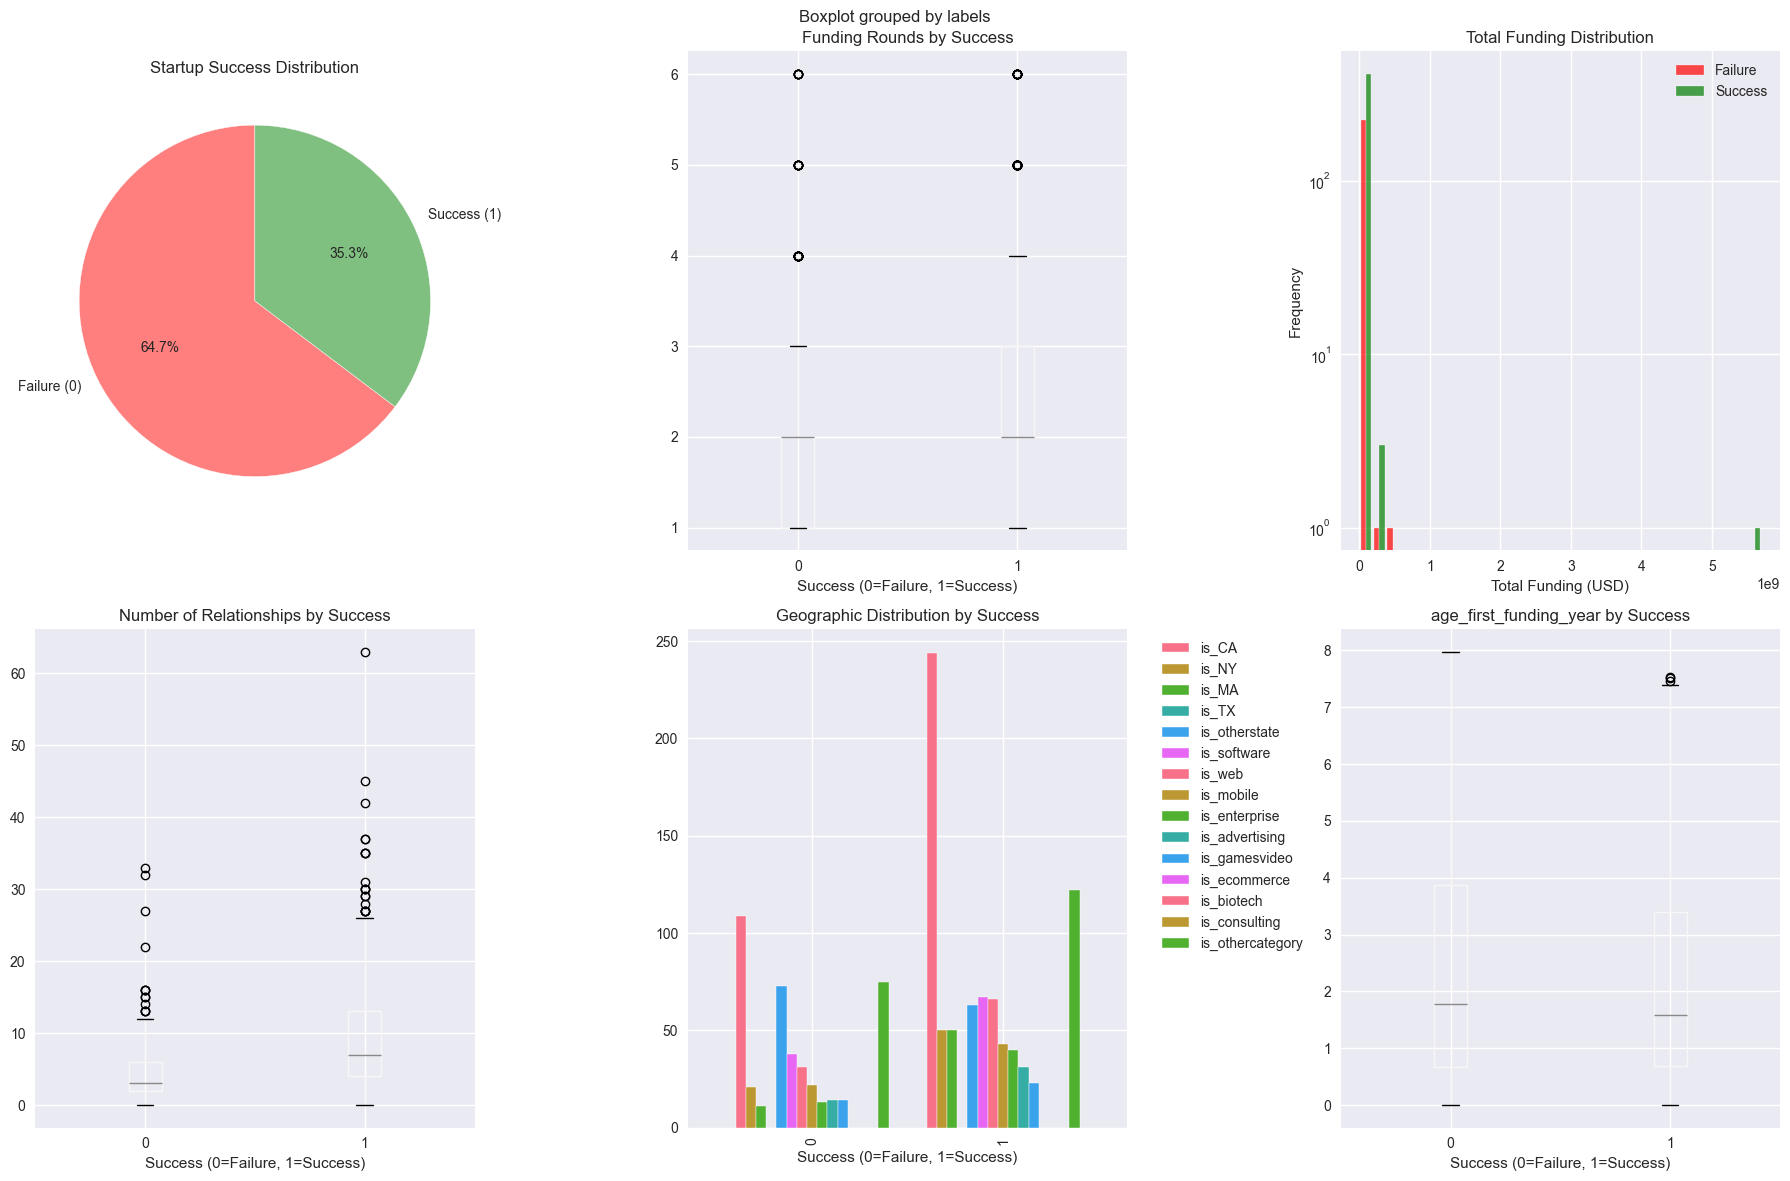

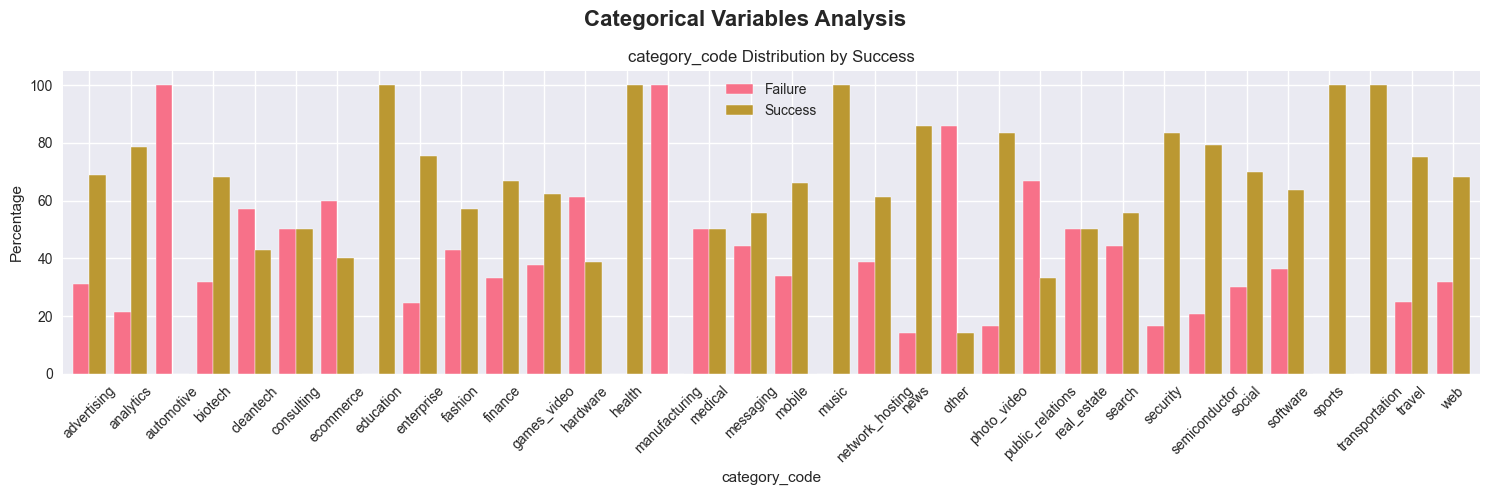


--- CORRELATION ANALYSIS ---


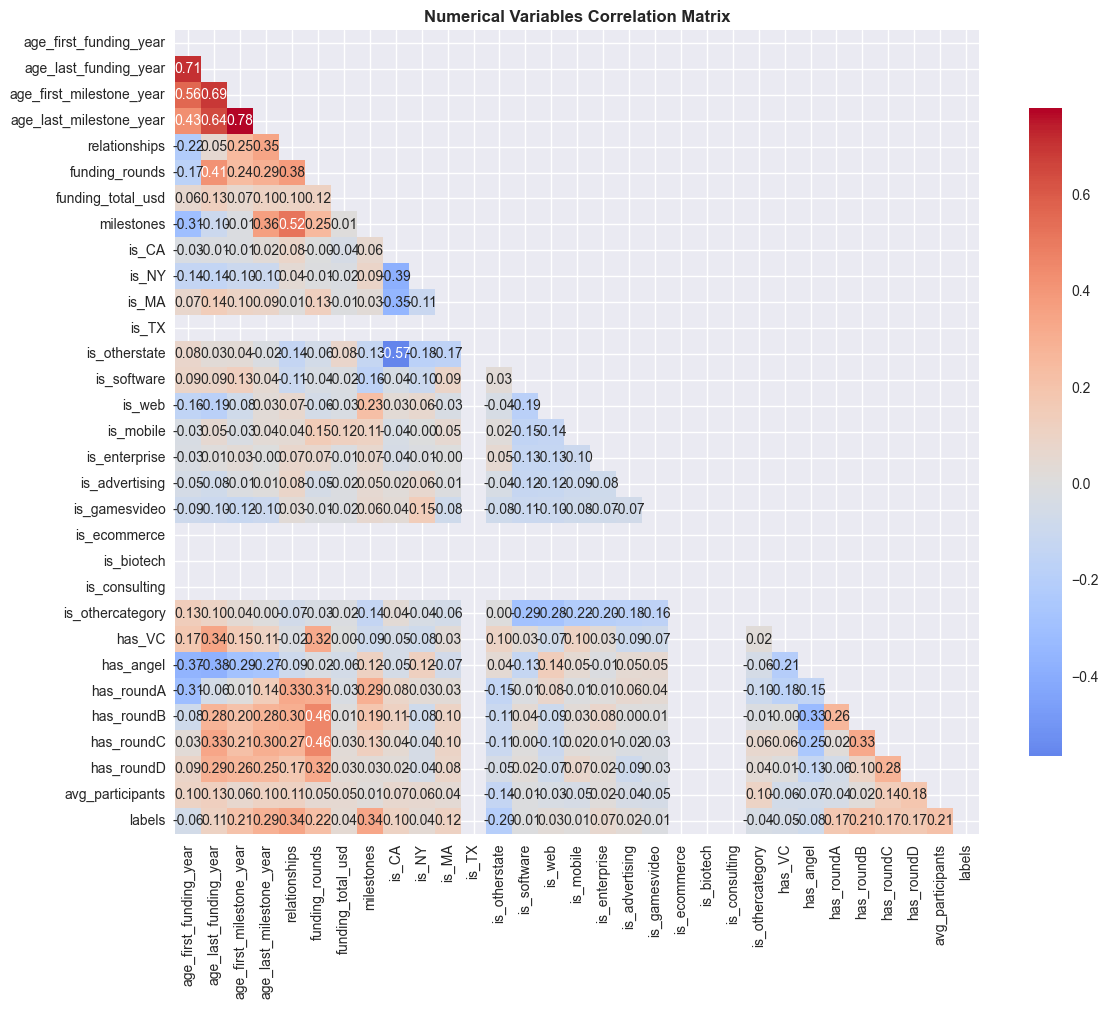

Strongest correlations with target variable:
  relationships: 0.343
  milestones: 0.335
  age_last_milestone_year: 0.287
  funding_rounds: 0.225
  has_roundB: 0.214
  avg_participants: 0.208
  age_first_milestone_year: 0.205
  is_otherstate: -0.199
  has_roundC: 0.173
  has_roundA: 0.172

--- CATEGORICAL PATTERN ANALYSIS ---

category_code:
  Success rate by category:
    health: 100.0% (2 samples)
    education: 100.0% (2 samples)
    sports: 100.0% (1 samples)
    music: 100.0% (5 samples)
    transportation: 100.0% (2 samples)
    news: 85.7% (7 samples)
    security: 83.3% (12 samples)
    photo_video: 83.3% (6 samples)
    semiconductor: 79.2% (24 samples)
    analytics: 78.6% (14 samples)
    enterprise: 75.5% (53 samples)
    travel: 75.0% (4 samples)
    social: 70.0% (10 samples)
    advertising: 68.9% (45 samples)
    web: 68.0% (97 samples)
    biotech: 68.0% (25 samples)
    finance: 66.7% (3 samples)
    mobile: 66.2% (65 samples)
    software: 63.8% (105 samples)
    game

<Figure size 1000x600 with 0 Axes>

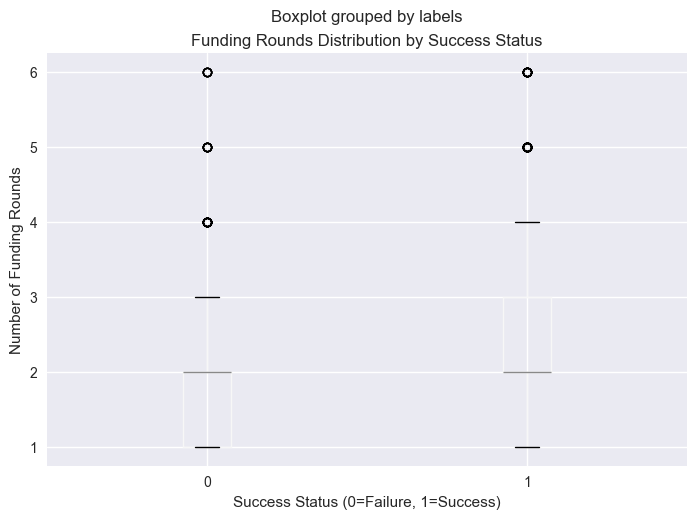


HYPOTHESIS 2: Impact of Age at First Funding
H2: Startups that obtain funding earlier have better chances of success
Justification: Early funding allows better product execution and adaptation

--- HYPOTHESIS 2 TEST ---
Average age at first funding - Success: 2.15, Failure: 2.43
Statistical test (ANOVA F-test): p-value = 0.1126
Hypothesis 2 NOT SUPPORTED: No significant difference


<Figure size 1000x600 with 0 Axes>

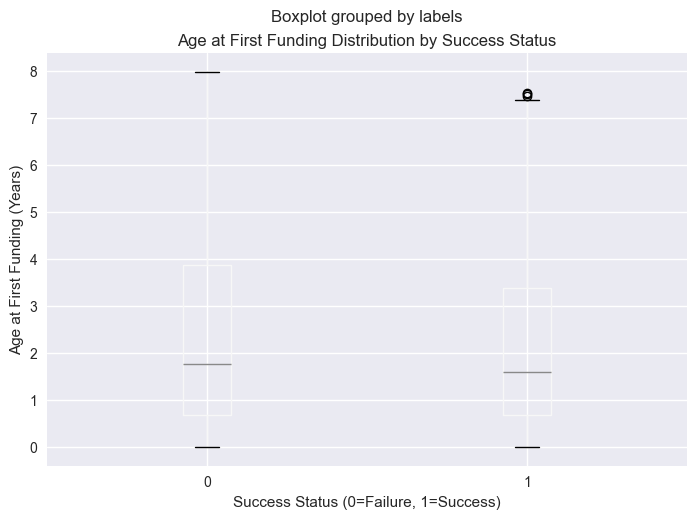


HYPOTHESIS 3: Impact of Relationship Network
H3: Startups with an extensive network (more relationships) have a higher success rate
Justification: An extensive network facilitates access to resources, partnerships and opportunities

--- HYPOTHESIS 3 TEST ---
Average relationships - Success: 9.82, Failure: 4.52
Statistical test (ANOVA F-test): p-value = 0.0000
Hypothesis 3 SUPPORTED: Significant difference in number of relationships


<Figure size 1000x600 with 0 Axes>

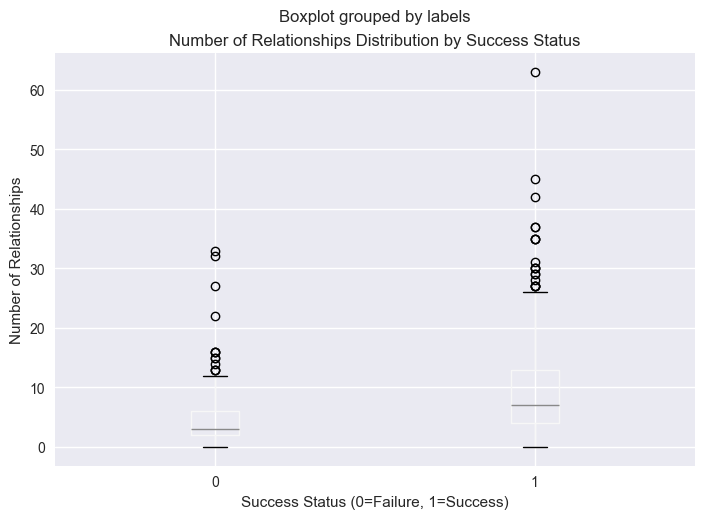


--- HYPOTHESIS TESTING SYNTHESIS ---
Summary of hypothesis testing results:
  Hypothesis 1 (funding_rounds): Supported
  Hypothesis 2 (early_funding): Not supported
  Hypothesis 3 (network): Supported

Total supported hypotheses: 2/3
Step 5 : Select most important features
5. FEATURE SELECTION
Initial number of features: 41

--- METHOD 1: STATISTICAL FEATURE SELECTION ---
Selected features (statistical): 20
Top 10 features: ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'milestones', 'is_CA', 'is_MA', 'is_otherstate']

--- METHOD 2: RANDOM FOREST FEATURE IMPORTANCE ---


C:\Users\Sacha Kefif\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [11 19 20 21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Sacha Kefif\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected features (Random Forest): 20
Top 10 features: ['relationships', 'funding_total_usd', 'age_last_milestone_year', 'age_last_funding_year', 'age_first_funding_year', 'milestones', 'age_first_milestone_year', 'avg_participants', 'funding_rounds', 'is_otherstate']

--- METHOD 3: RECURSIVE FEATURE ELIMINATION ---
Selected features (RFE): 20
Top 10 features: ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_otherstate']

--- FEATURE SELECTION COMBINATION ---
Final selected features: 14


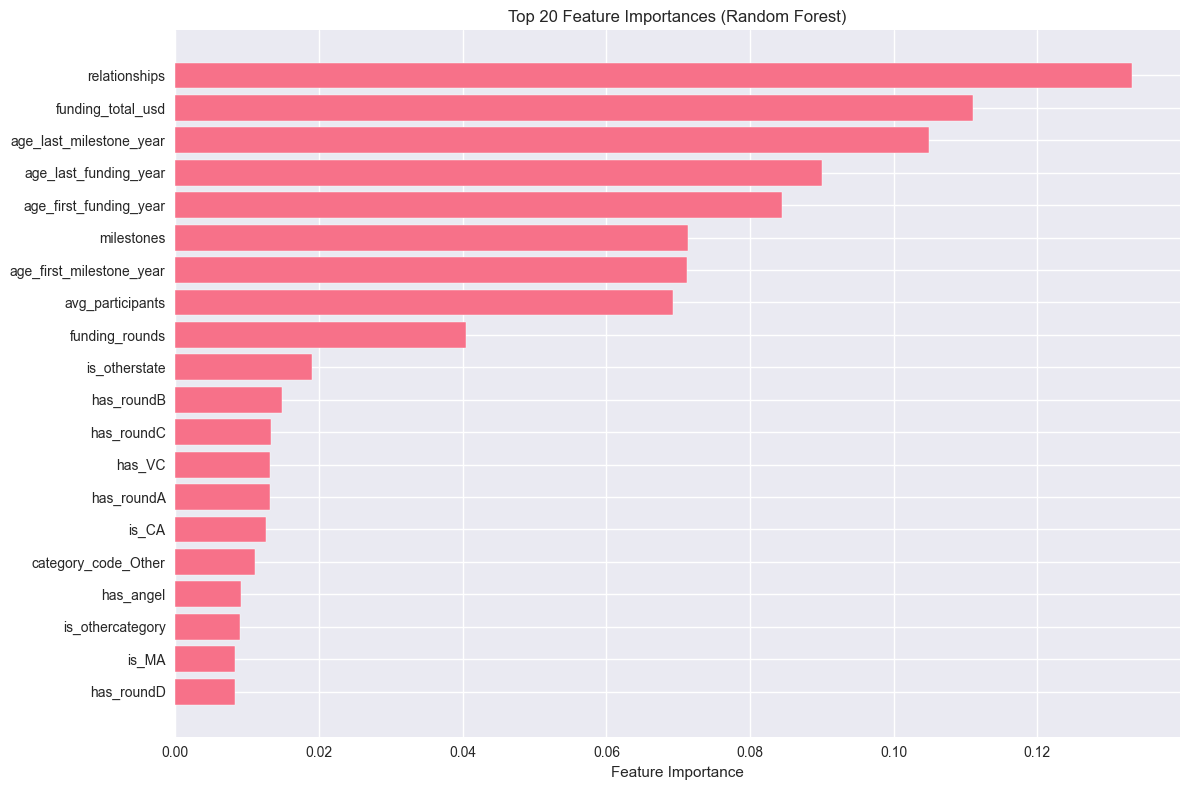

Step 6 : Build Bootstrap + Aggregation model
6. BOOTSTRAP + AGGREGATION MODEL CONSTRUCTION
Training set: (516, 14)
Validation set: (130, 14)

--- BOOTSTRAP + AGGREGATION (20 models) ---

Training bagged model 1/20...
  Bootstrap sample size: 516 (unique: 338)
  Individual model accuracy: 0.7846

Training bagged model 2/20...
  Bootstrap sample size: 516 (unique: 340)
  Individual model accuracy: 0.7692

Training bagged model 3/20...
  Bootstrap sample size: 516 (unique: 333)
  Individual model accuracy: 0.8231

Training bagged model 4/20...
  Bootstrap sample size: 516 (unique: 316)
  Individual model accuracy: 0.8077

Training bagged model 5/20...
  Bootstrap sample size: 516 (unique: 320)
  Individual model accuracy: 0.8077

Training bagged model 6/20...
  Bootstrap sample size: 516 (unique: 318)
  Individual model accuracy: 0.7846

Training bagged model 7/20...
  Bootstrap sample size: 516 (unique: 317)
  Individual model accuracy: 0.8077

Training bagged model 8/20...
  Bootstrap s

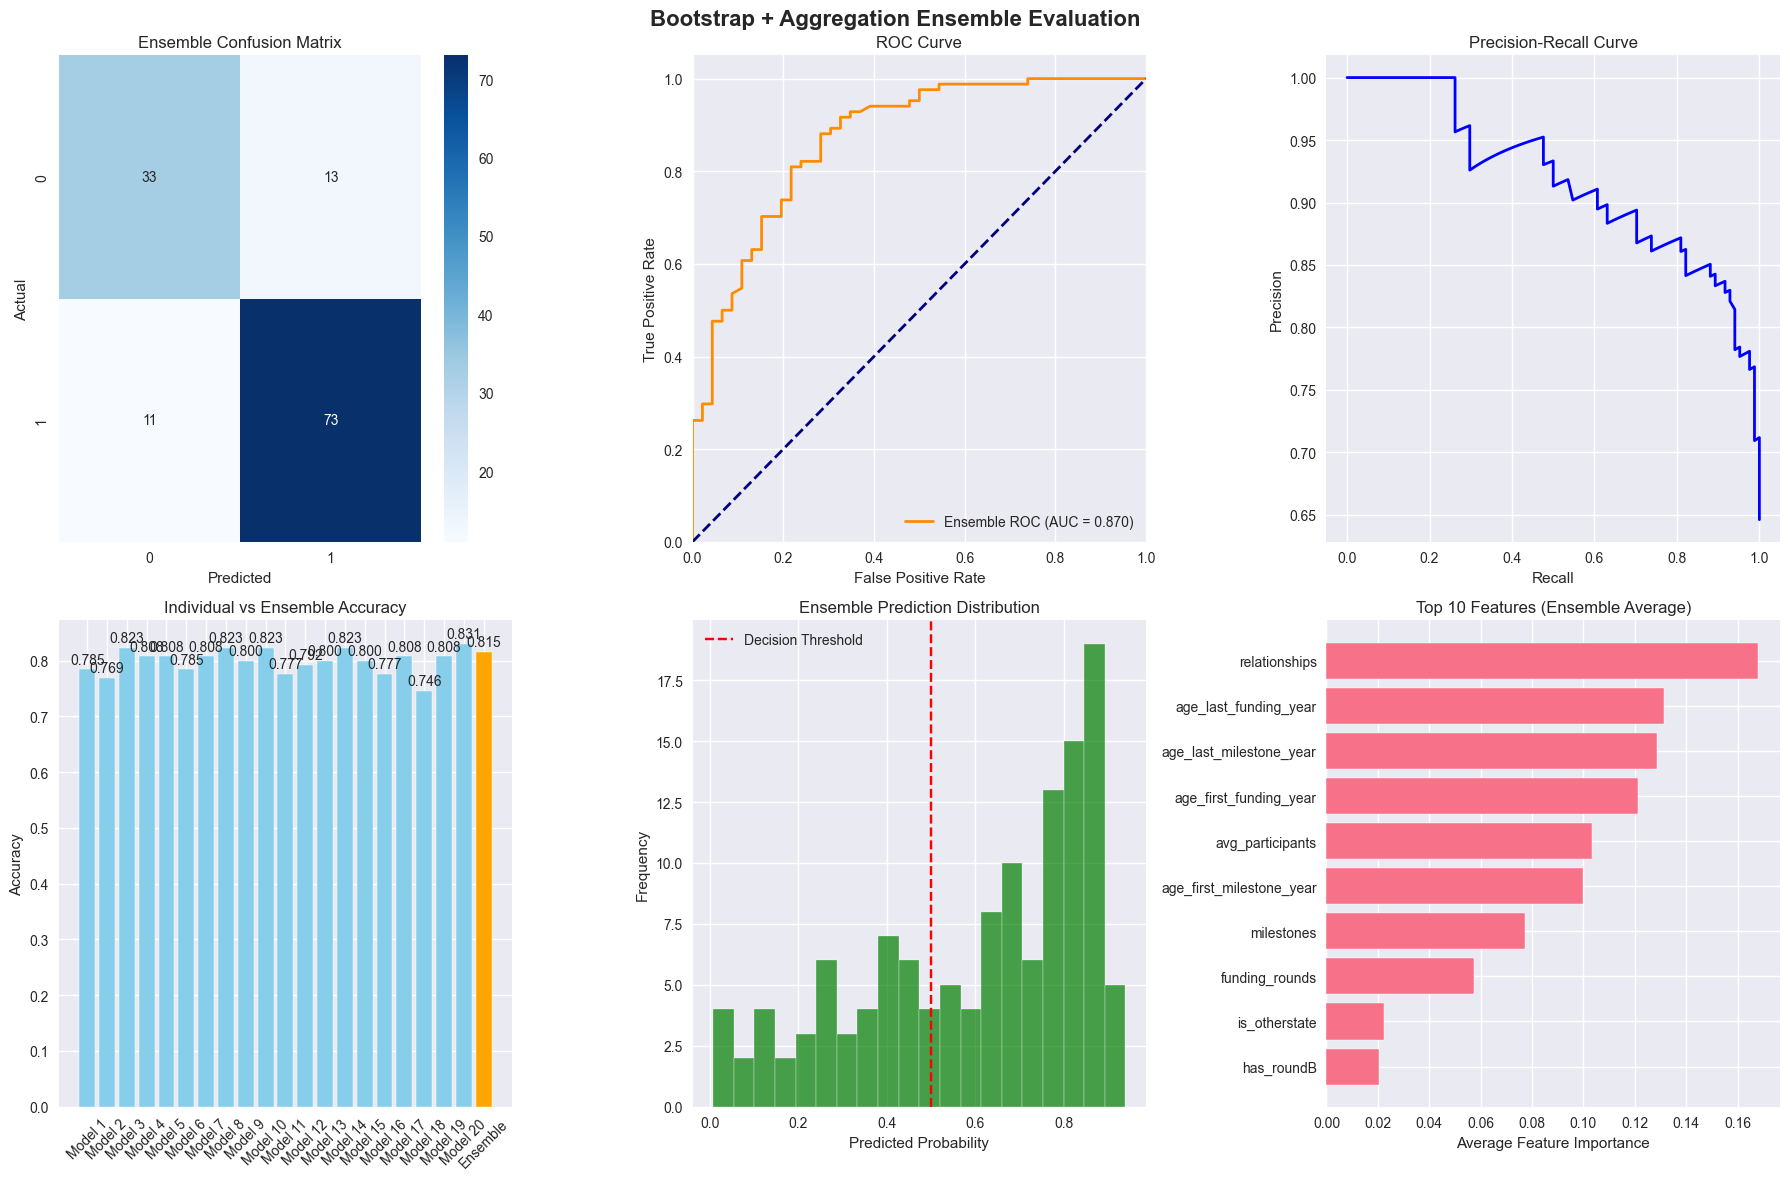

Step 7 : Perform hyperparameter tuning
7. HYPERPARAMETER FINE-TUNING
Parameter grid defined with combinations: 8640

--- RANDOMIZED SEARCH CV ---
Starting randomized search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'n_estimators': 175, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 6, 'bootstrap': True}
Best cross-validation score: 0.7987

--- FINE-TUNING AROUND BEST PARAMETERS ---
Starting fine-tuning grid search...
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Final best parameters: {'bootstrap': True, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 125}
Final best cross-validation score: 0.7941

--- TUNED MODEL EVALUATION ---
Tuned model accuracy on validation set: 0.9000

Top 10 most important features:
  relationships: 0.2131
  age_last_milestone_year: 0.1457
  milestones: 0.1173
  age_last_funding_year: 0.1116
  avg_partici

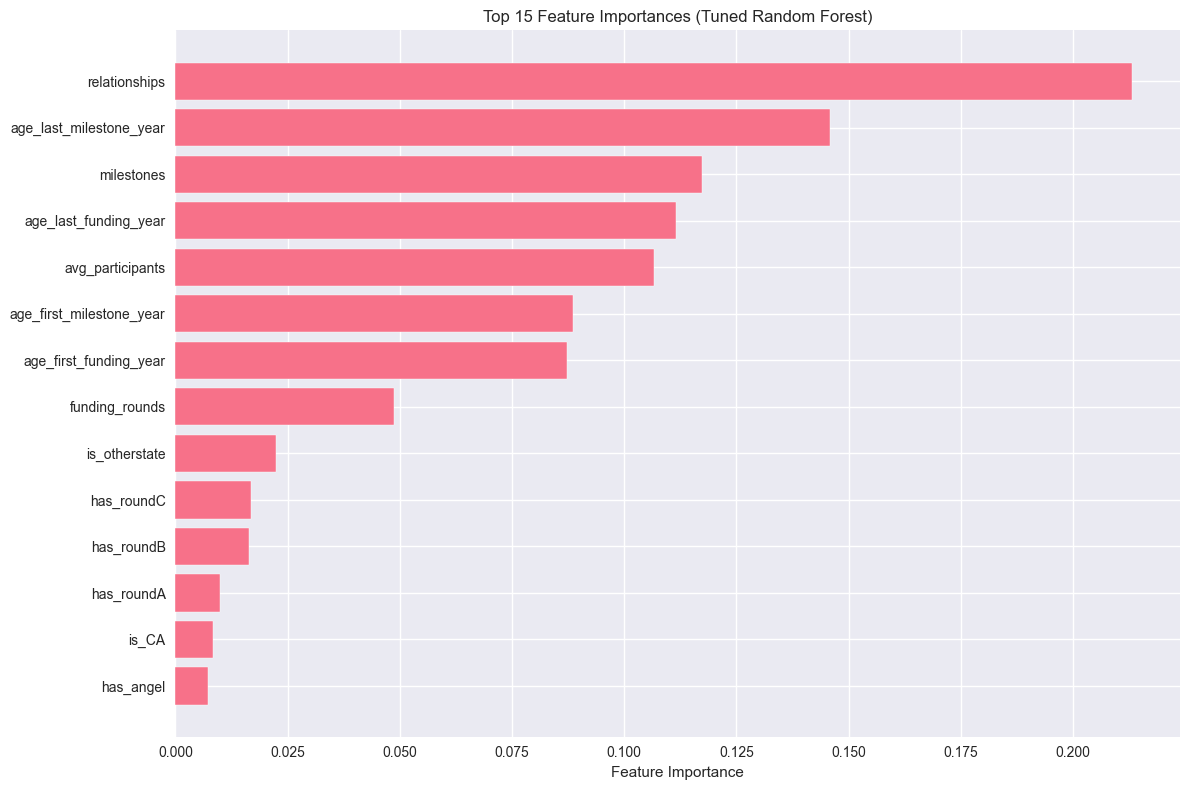


COMPARING BAGGING VS TUNED MODEL PERFORMANCE
Bagging Model Accuracy : 0.8154
Tuned Model Accuracy : 0.9000
SELECTED : Tuned Model (Better performance: 0.9000)
Step 8 : Generate final predictions on test set
8. MINIMUM ACCURACY ACHIEVEMENT & FINAL PREDICTIONS
--- FINAL MODEL PERFORMANCE ---
Final Validation Accuracy: 0.9000
Final Validation Precision: 0.8817
Final Validation Recall: 0.9762
Final Validation F1-Score: 0.9266
Final Validation ROC AUC: 0.9601

--- GENERATING TEST PREDICTIONS ---
Generating predictions
Test predictions generated for 277 samples
Predicted success rate: 73.3%
Using actual test IDs from test.csv (first 5 IDs: [ 70  23 389 872 920])
Submission file saved in ../Submissions/final_submission.csv
Submission with probabilities saved: ../Submissions/final_submission_with_probabilities.csv

PIPELINE COMPLETED
Final Model Accuracy: 0.9000
Submissions saved with enhanced bagging predictions.


In [640]:
final_accuracy, test_predictions = run_complete_pipeline()

## Accuracy Result And Summary

In [641]:
if final_accuracy is not None:
    print(f"FINAL ACCURACY : {final_accuracy:.4f}")
    # print(f"TEST PREDICTIONS : {test_predictions:.4f}")

FINAL ACCURACY : 0.9000
